In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ADS/Classification')
import adsa_utils as ad

## The Student Dataset

In [4]:
# load the risk data
student = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ADS/Classification/assessment_student_dataset.csv', sep=';')
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1131 non-null   int64  
 1   Auditory              1131 non-null   float64
 2   Kinaesthetic          1131 non-null   float64
 3   Visual                1131 non-null   float64
 4   Extrinsic Motivation  1131 non-null   float64
 5   Intrinsic Motivation  1131 non-null   float64
 6   Self-Efficacy         1131 non-null   float64
 7   Study Time            1131 non-null   float64
 8   Conscientiousness     1131 non-null   float64
 9   CAO Points            1131 non-null   float64
 10  Maths                 1131 non-null   float64
 11  English               1131 non-null   float64
 12  Pass                  1131 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 115.0+ KB


In [5]:
# get the distribution of values in the class label column
student.Pass.value_counts()

,count
Pass,
Pass,711
Fail,420


In [6]:
# separate the class label from regular attributes
y = student[['Pass']]
X = student[student.columns.difference(['Pass'])]
# drop the ID column
# X = X.drop(columns=['ID'])

In [7]:
# split the dataset into 2 portions:
# one for training and validation, one for the final testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43
)


## Scikitlearn DecisionTreeClassifier

### Necessary preparation
- the algorithm accepts numerical values only, so we will use the OrdinalEncoder to convert categorical/nominal columns to numeric.  Note however, that the student dataset contains only one categorical columns, that is the target feature, 'Pass'.

In [8]:
# make a copy of the training regular data
dt_X = X_train.copy()
# get the categorical columns
cat_cols = dt_X.select_dtypes(include='object').columns
# encode those categorical columns using an OrdinalEncoder instance
dt_X[cat_cols] = OrdinalEncoder().fit_transform(dt_X[cat_cols])
dt_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 904 entries, 1053 to 255
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Auditory              904 non-null    float64
 1   CAO Points            904 non-null    float64
 2   Conscientiousness     904 non-null    float64
 3   English               904 non-null    float64
 4   Extrinsic Motivation  904 non-null    float64
 5   Intrinsic Motivation  904 non-null    float64
 6   Kinaesthetic          904 non-null    float64
 7   Maths                 904 non-null    float64
 8   Self-Efficacy         904 non-null    float64
 9   Study Time            904 non-null    float64
 10  Visual                904 non-null    float64
 11  age                   904 non-null    int64  
dtypes: float64(11), int64(1)
memory usage: 91.8 KB


### Baseline

In [ ]:
# create an instance of the DT classifier leaving
# all hyperparameters to default values except random_state
dt_clf = DecisionTreeClassifier(random_state=43)

Mean accuracy: 75.11% +/-2.20%
Mean precision: 73.40% +/-2.28%
Mean recall: 73.59% +/-2.47%
Mean F1-score is 73.40% +/-2.36%
              precision    recall  f1-score   support

        Fail       0.66      0.68      0.67       333
        Pass       0.81      0.79      0.80       571

    accuracy                           0.75       904
   macro avg       0.73      0.74      0.73       904
weighted avg       0.75      0.75      0.75       904



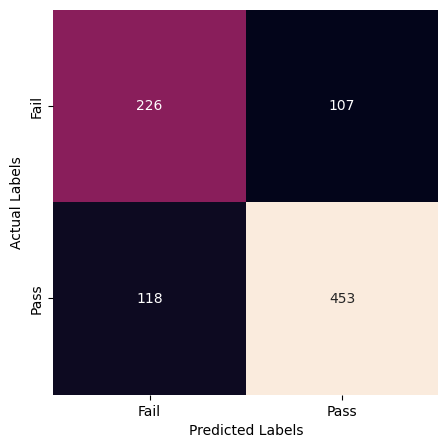

In [ ]:
# crossvalidate on the encoded train portion using the custom function
ad.custom_crossvalidation(dt_X, y_train, dt_clf)

[Text(0.62225341796875, 0.9666666666666667, 'Maths <= 45.5\ngini = 0.465\nsamples = 904\nvalue = [333, 571]\nclass = Pass'),
 Text(0.324462890625, 0.9, 'age <= 20.5\ngini = 0.494\nsamples = 589\nvalue = [261, 328]\nclass = Pass'),
 Text(0.473358154296875, 0.9333333333333333, 'True  '),
 Text(0.112548828125, 0.8333333333333334, 'Maths <= 32.5\ngini = 0.468\nsamples = 220\nvalue = [138, 82]\nclass = Fail'),
 Text(0.05859375, 0.7666666666666667, 'Auditory <= 2.423\ngini = 0.365\nsamples = 129\nvalue = [98, 31]\nclass = Fail'),
 Text(0.03125, 0.7, 'Intrinsic Motivation <= 7.04\ngini = 0.498\nsamples = 30\nvalue = [14, 16]\nclass = Pass'),
 Text(0.015625, 0.6333333333333333, 'Visual <= 7.667\ngini = 0.36\nsamples = 17\nvalue = [13, 4]\nclass = Fail'),
 Text(0.0078125, 0.5666666666666667, 'gini = 0.0\nsamples = 12\nvalue = [12, 0]\nclass = Fail'),
 Text(0.0234375, 0.5666666666666667, 'Conscientiousness <= 6.038\ngini = 0.32\nsamples = 5\nvalue = [1, 4]\nclass = Pass'),
 Text(0.015625, 0.5, '

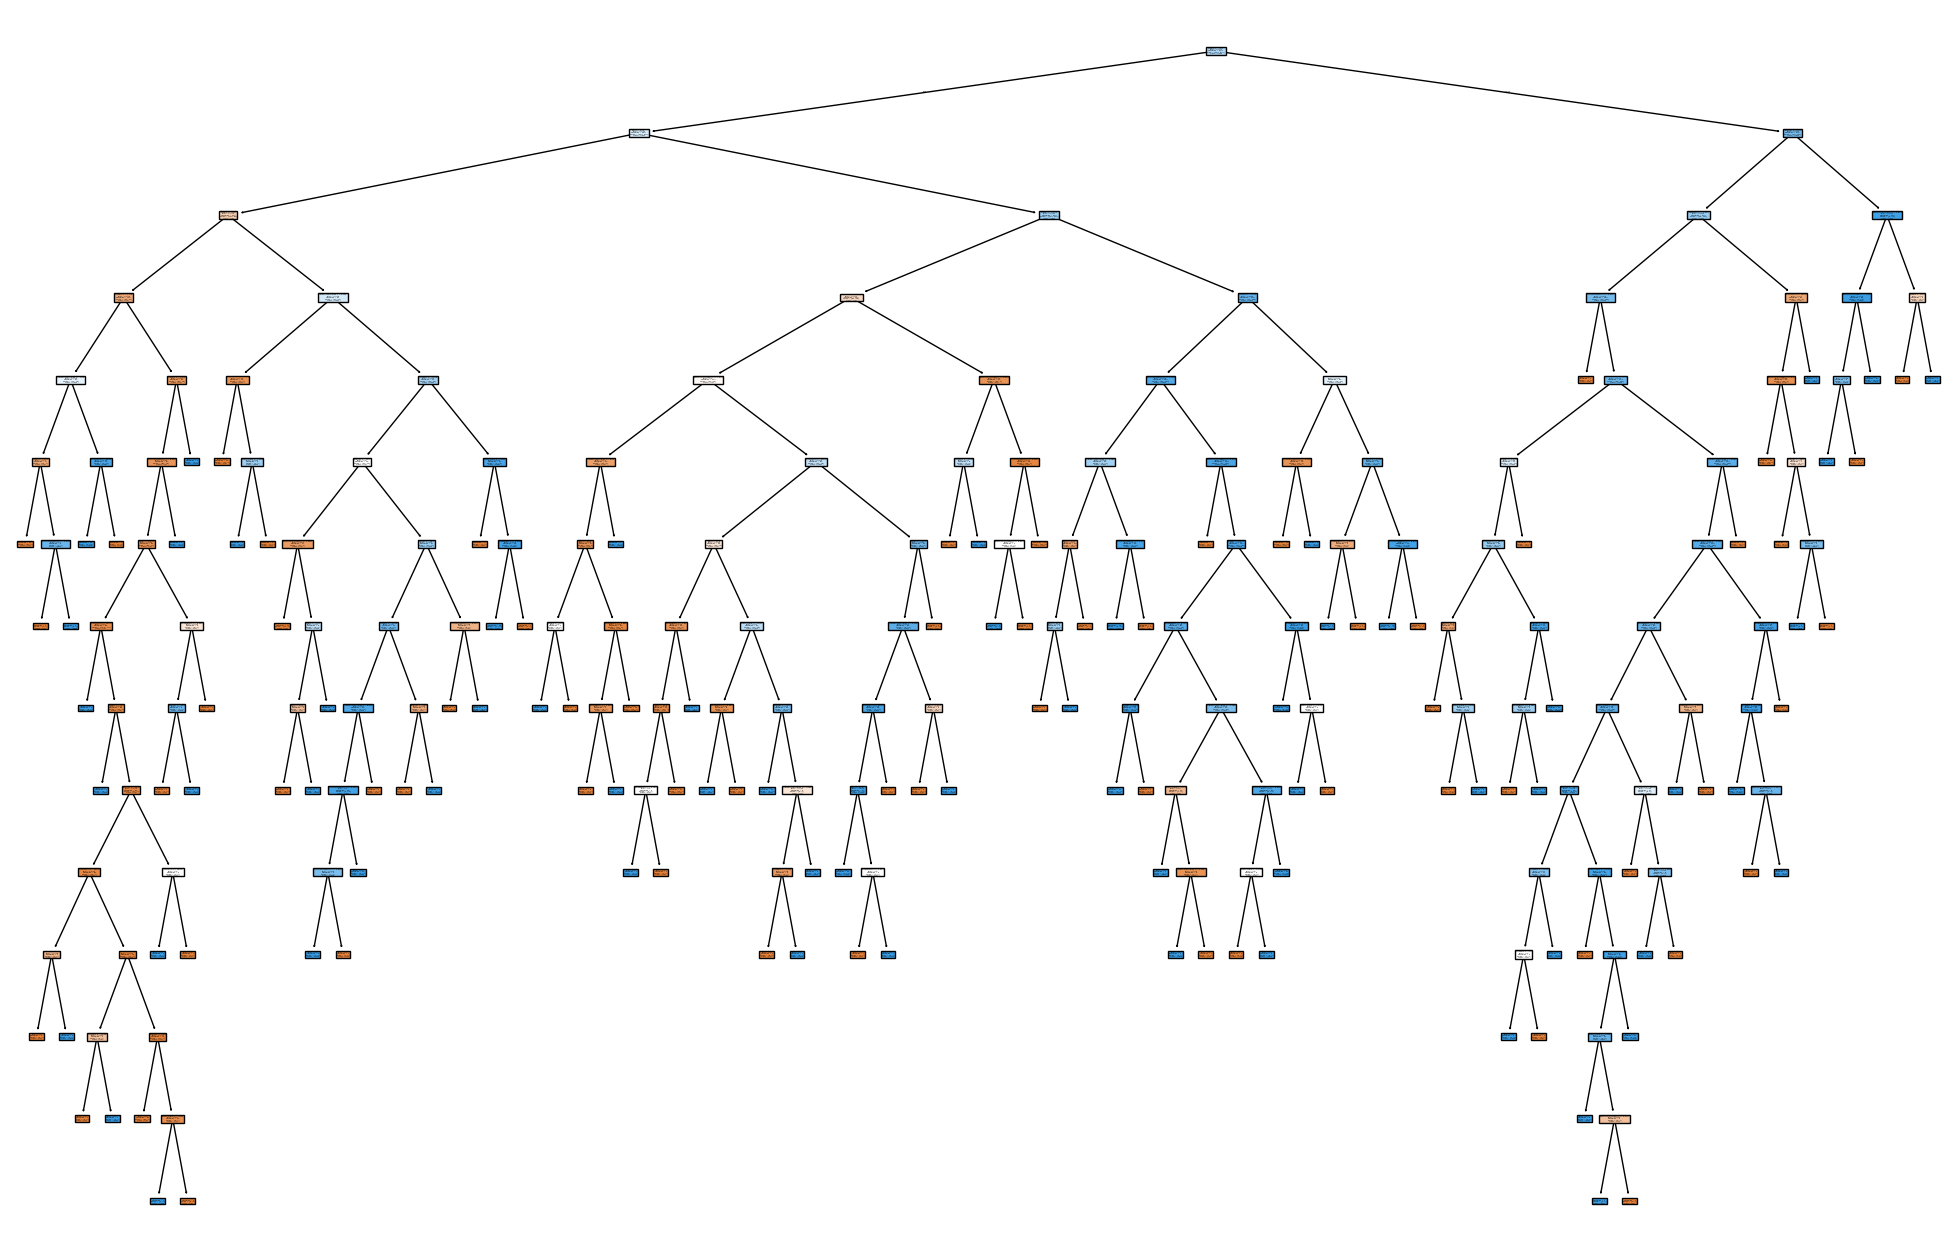

In [ ]:
# get the tree model
dt_clf.fit(dt_X, y_train)
plt.figure(figsize=(25, 16))
plot_tree(dt_clf, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf.classes_)

In [ ]:
# can output the depth and the number of leaf nodes
dt_clf.get_depth(), dt_clf.get_n_leaves()

(14, 126)

In [ ]:
print(dt_clf.classes_)

['Fail' 'Pass']


In [ ]:
dt_clf.decision_path(dt_X, check_input=True)

<904x251 sparse matrix of type '<class 'numpy.int64'>'
	with 8415 stored elements in Compressed Sparse Row format>

Modification of Selection Criteria from Gini to Entropy

Mean accuracy: 73.34% +/-1.97%
Mean precision: 71.52% +/-2.20%
Mean recall: 71.53% +/-2.55%
Mean F1-score is 71.39% +/-2.17%
              precision    recall  f1-score   support

        Fail       0.64      0.65      0.64       333
        Pass       0.79      0.78      0.79       571

    accuracy                           0.73       904
   macro avg       0.71      0.72      0.71       904
weighted avg       0.73      0.73      0.73       904



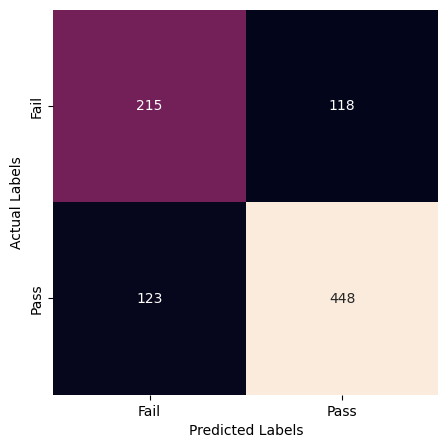

In [ ]:
dt_clf1a = DecisionTreeClassifier(criterion='entropy', random_state=43)
ad.custom_crossvalidation(dt_X, y_train, dt_clf1a)

[Text(0.7523376901849642, 0.9722222222222222, 'CAO Points <= 487.0\nentropy = 0.949\nsamples = 904\nvalue = [333, 571]\nclass = Pass'),
 Text(0.5297350462410502, 0.9166666666666666, 'Visual <= 7.504\nentropy = 0.97\nsamples = 821\nvalue = [327, 494]\nclass = Pass'),
 Text(0.6410363682130071, 0.9444444444444444, 'True  '),
 Text(0.2996252237470167, 0.8611111111111112, 'Extrinsic Motivation <= 6.769\nentropy = 1.0\nsamples = 500\nvalue = [247, 253]\nclass = Pass'),
 Text(0.03818615751789976, 0.8055555555555556, 'Self-Efficacy <= 5.829\nentropy = 0.787\nsamples = 68\nvalue = [52, 16]\nclass = Fail'),
 Text(0.028639618138424822, 0.75, 'entropy = 0.0\nsamples = 22\nvalue = [22, 0]\nclass = Fail'),
 Text(0.0477326968973747, 0.75, 'Study Time <= 3.79\nentropy = 0.932\nsamples = 46\nvalue = [30, 16]\nclass = Fail'),
 Text(0.03818615751789976, 0.6944444444444444, 'entropy = 0.0\nsamples = 15\nvalue = [15, 0]\nclass = Fail'),
 Text(0.057279236276849645, 0.6944444444444444, 'Extrinsic Motivation 

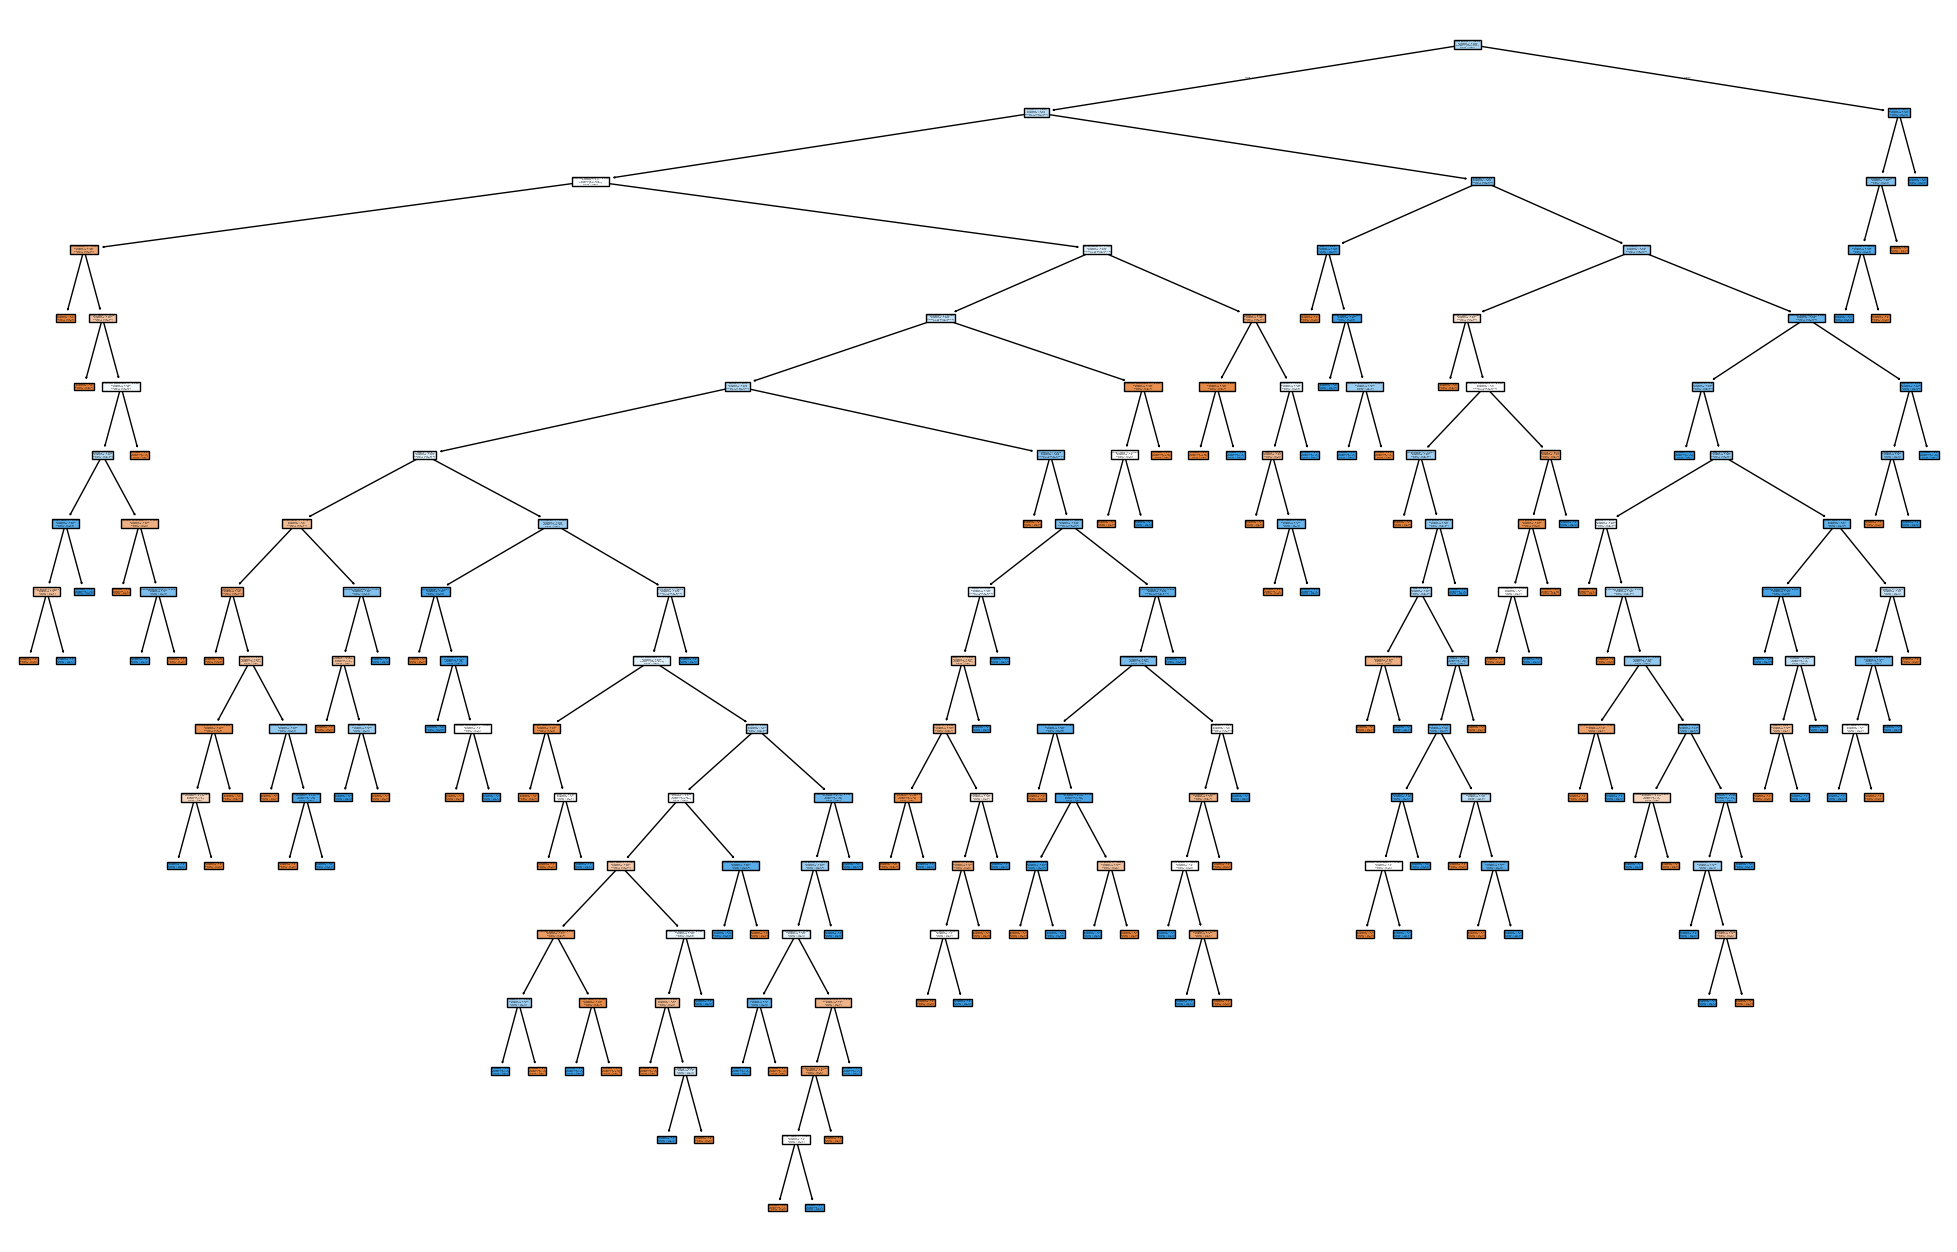

In [ ]:
dt_clf1a.fit(dt_X, y_train)
plt.figure(figsize=(25, 16))
plot_tree(dt_clf1a, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf1a.classes_)

In [ ]:
dt_clf1a.get_depth(), dt_clf1a.get_n_leaves()

(17, 121)

### Pruning
- we can manually modify various hyperparameters:
1. Pre-Pruning Hyperparameters: max_depth, min_samples_split, min_samples_leaf
2. Post-Pruning Hyperparameter: ccp_alpha

Mean accuracy: 74.78% +/-1.37%
Mean precision: 72.93% +/-1.42%
Mean recall: 72.40% +/-1.51%
Mean F1-score is 72.60% +/-1.46%
              precision    recall  f1-score   support

        Fail       0.67      0.63      0.65       333
        Pass       0.79      0.81      0.80       571

    accuracy                           0.75       904
   macro avg       0.73      0.72      0.73       904
weighted avg       0.75      0.75      0.75       904



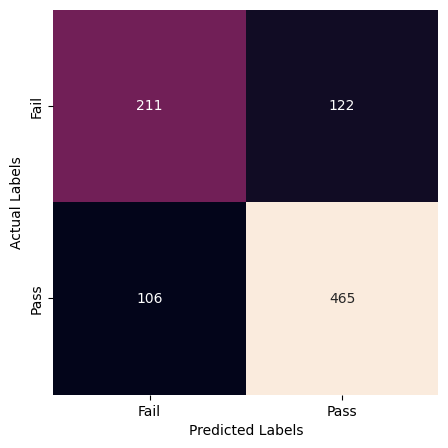

8 38


[Text(0.5861111111111111, 0.9444444444444444, 'Maths <= 45.5\ngini = 0.465\nsamples = 904\nvalue = [333, 571]\nclass = Pass'),
 Text(0.3, 0.8333333333333334, 'age <= 20.5\ngini = 0.494\nsamples = 589\nvalue = [261, 328]\nclass = Pass'),
 Text(0.44305555555555554, 0.8888888888888888, 'True  '),
 Text(0.14444444444444443, 0.7222222222222222, 'Maths <= 32.5\ngini = 0.468\nsamples = 220\nvalue = [138, 82]\nclass = Fail'),
 Text(0.06666666666666667, 0.6111111111111112, 'Auditory <= 2.423\ngini = 0.365\nsamples = 129\nvalue = [98, 31]\nclass = Fail'),
 Text(0.044444444444444446, 0.5, 'gini = 0.498\nsamples = 30\nvalue = [14, 16]\nclass = Pass'),
 Text(0.08888888888888889, 0.5, 'Extrinsic Motivation <= 7.78\ngini = 0.257\nsamples = 99\nvalue = [84, 15]\nclass = Fail'),
 Text(0.044444444444444446, 0.3888888888888889, 'Conscientiousness <= 5.311\ngini = 0.15\nsamples = 61\nvalue = [56, 5]\nclass = Fail'),
 Text(0.022222222222222223, 0.2777777777777778, 'gini = 0.346\nsamples = 18\nvalue = [14, 

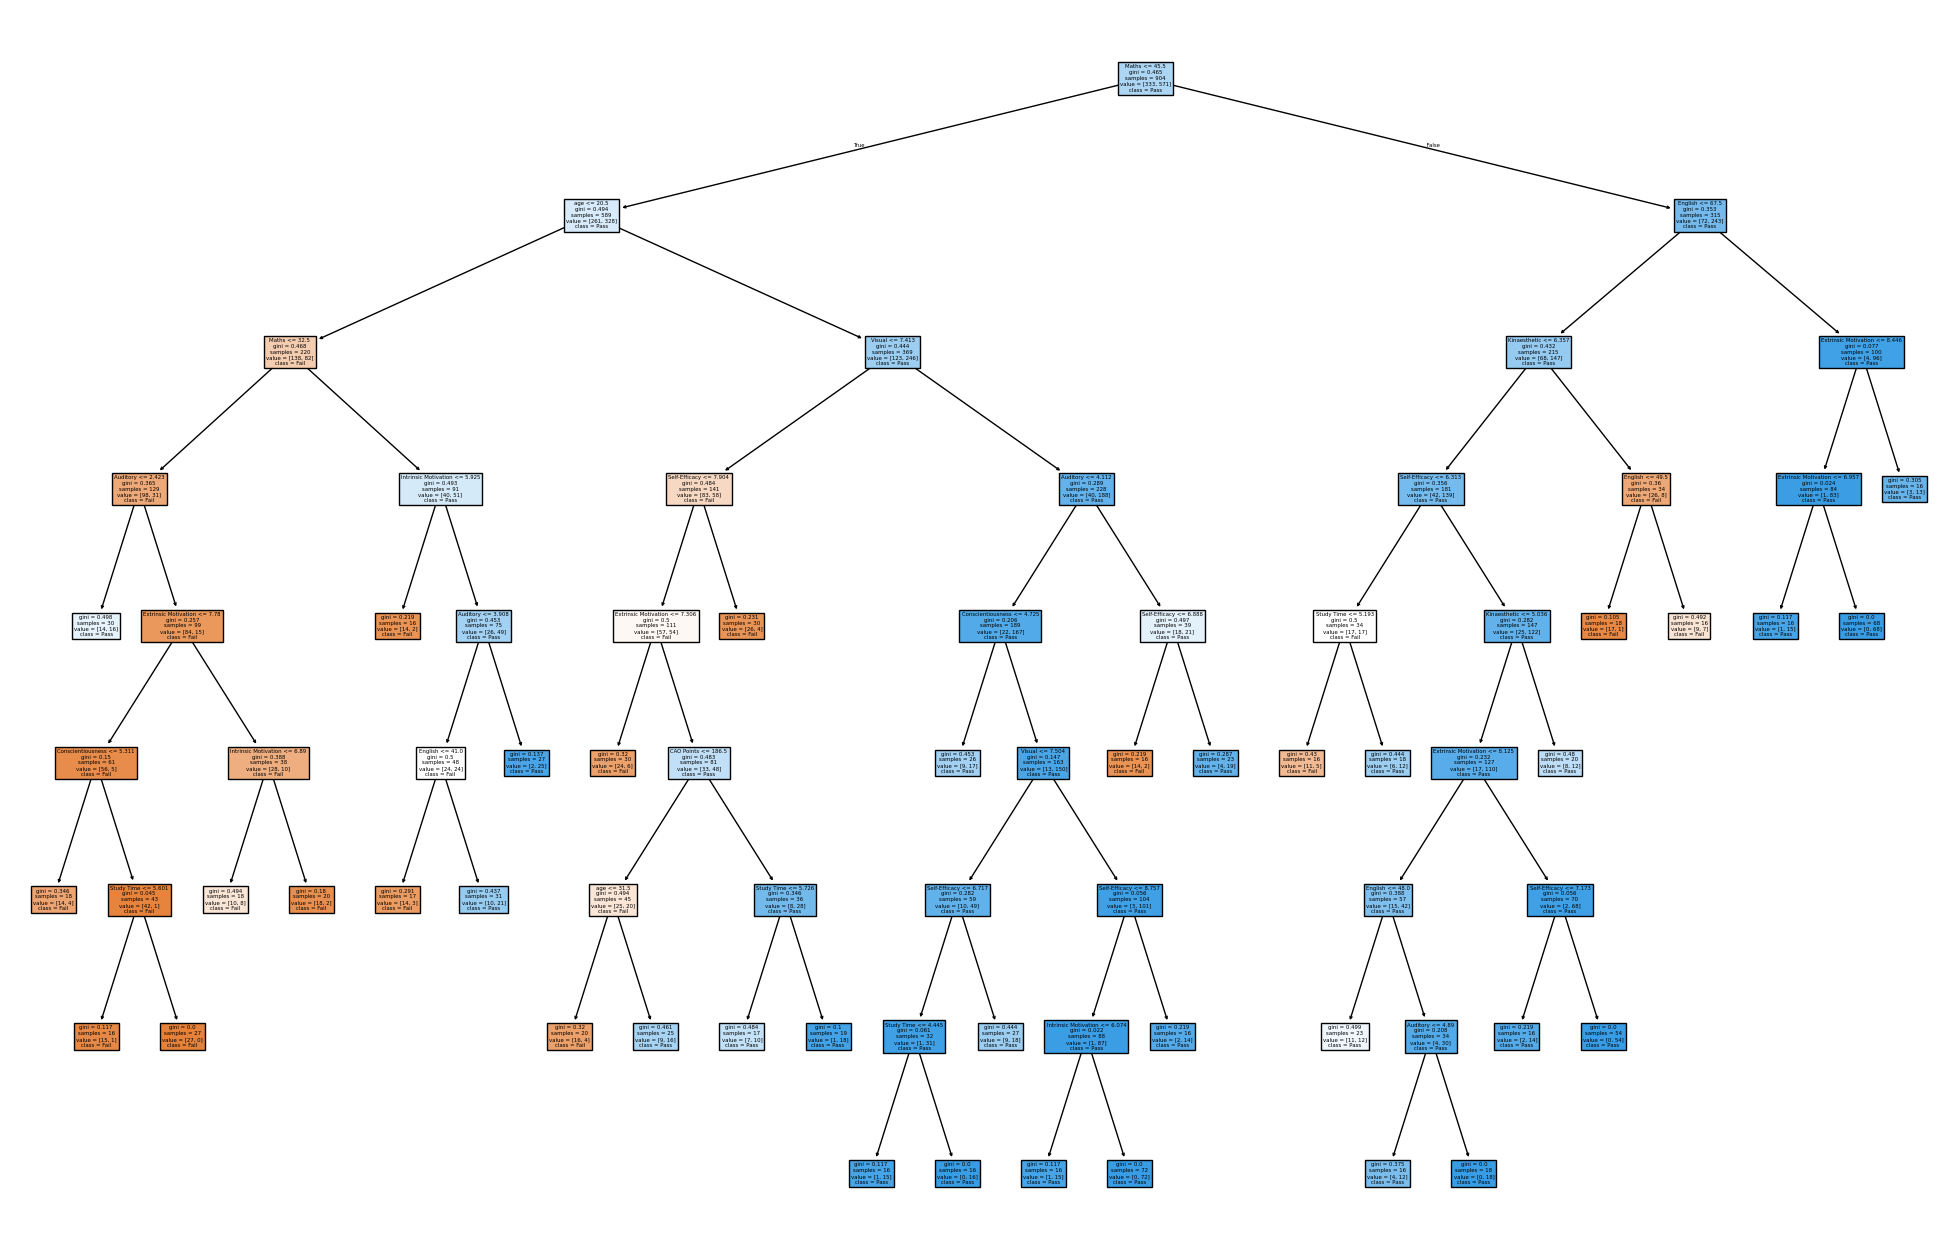

In [ ]:
# prepruning
dt_clf2 = DecisionTreeClassifier(max_depth=8, min_samples_split=10, max_leaf_nodes=75,
                                min_samples_leaf=16, random_state=43)
ad.custom_crossvalidation(dt_X, y_train, dt_clf2)
dt_clf2.fit(dt_X, y_train)
print(dt_clf2.get_depth(), dt_clf2.get_n_leaves())
plt.figure(figsize=(25, 16))
plot_tree(dt_clf2, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf2.classes_)

Check: Run optimal pre pruning parameters against the test data to see if run 9 generalises better than run 8


Mean accuracy: 67.82% +/-8.25%
Mean precision: 66.37% +/-9.24%
Mean recall: 66.93% +/-9.82%
Mean F1-score is 66.16% +/-9.45%
              precision    recall  f1-score   support

        Fail       0.57      0.63      0.60        87
        Pass       0.76      0.71      0.73       140

    accuracy                           0.68       227
   macro avg       0.66      0.67      0.67       227
weighted avg       0.69      0.68      0.68       227



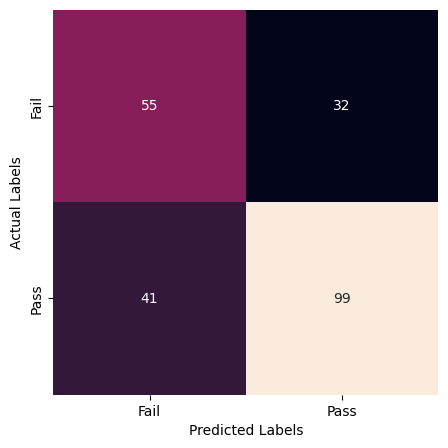

              precision    recall  f1-score   support

        Fail       0.42      0.69      0.52        87
        Pass       0.68      0.41      0.52       140

    accuracy                           0.52       227
   macro avg       0.55      0.55      0.52       227
weighted avg       0.58      0.52      0.52       227



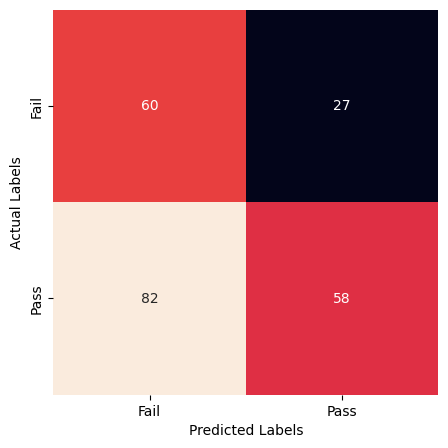

In [ ]:
pipeline = Pipeline([
    # unknown categories are handled by mapping them to -1
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('classifier', dt_clf2)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
ad.custom_crossvalidation(X_test, y_test, dt_clf2)
print(classification_report(y_test, y_pred))
ad.plot_confusion_matrix(y_test, y_pred)

In [ ]:
dt_clf2.get_depth(), dt_clf2.get_n_leaves()

(10, 75)

Mean accuracy: 74.45% +/-1.74%
Mean precision: 73.50% +/-2.47%
Mean recall: 71.73% +/-2.84%
Mean F1-score is 71.75% +/-2.35%
              precision    recall  f1-score   support

        Fail       0.67      0.61      0.64       333
        Pass       0.78      0.82      0.80       571

    accuracy                           0.74       904
   macro avg       0.73      0.72      0.72       904
weighted avg       0.74      0.74      0.74       904



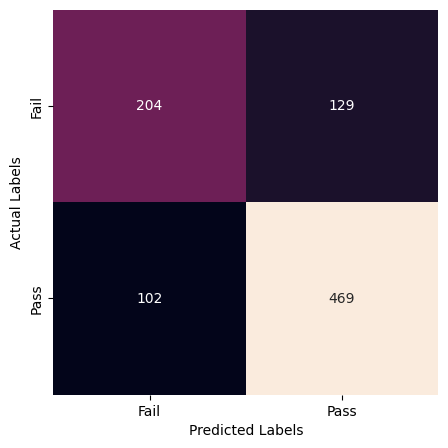

5 14


[Text(0.6071428571428571, 0.9166666666666666, 'Maths <= 45.5\ngini = 0.465\nsamples = 904\nvalue = [333, 571]\nclass = Pass'),
 Text(0.35714285714285715, 0.75, 'age <= 20.5\ngini = 0.494\nsamples = 589\nvalue = [261, 328]\nclass = Pass'),
 Text(0.4821428571428571, 0.8333333333333333, 'True  '),
 Text(0.23809523809523808, 0.5833333333333334, 'Maths <= 32.5\ngini = 0.468\nsamples = 220\nvalue = [138, 82]\nclass = Fail'),
 Text(0.14285714285714285, 0.4166666666666667, 'Auditory <= 2.423\ngini = 0.365\nsamples = 129\nvalue = [98, 31]\nclass = Fail'),
 Text(0.09523809523809523, 0.25, 'Intrinsic Motivation <= 7.04\ngini = 0.498\nsamples = 30\nvalue = [14, 16]\nclass = Pass'),
 Text(0.047619047619047616, 0.08333333333333333, 'gini = 0.36\nsamples = 17\nvalue = [13, 4]\nclass = Fail'),
 Text(0.14285714285714285, 0.08333333333333333, 'gini = 0.142\nsamples = 13\nvalue = [1, 12]\nclass = Pass'),
 Text(0.19047619047619047, 0.25, 'gini = 0.257\nsamples = 99\nvalue = [84, 15]\nclass = Fail'),
 Text

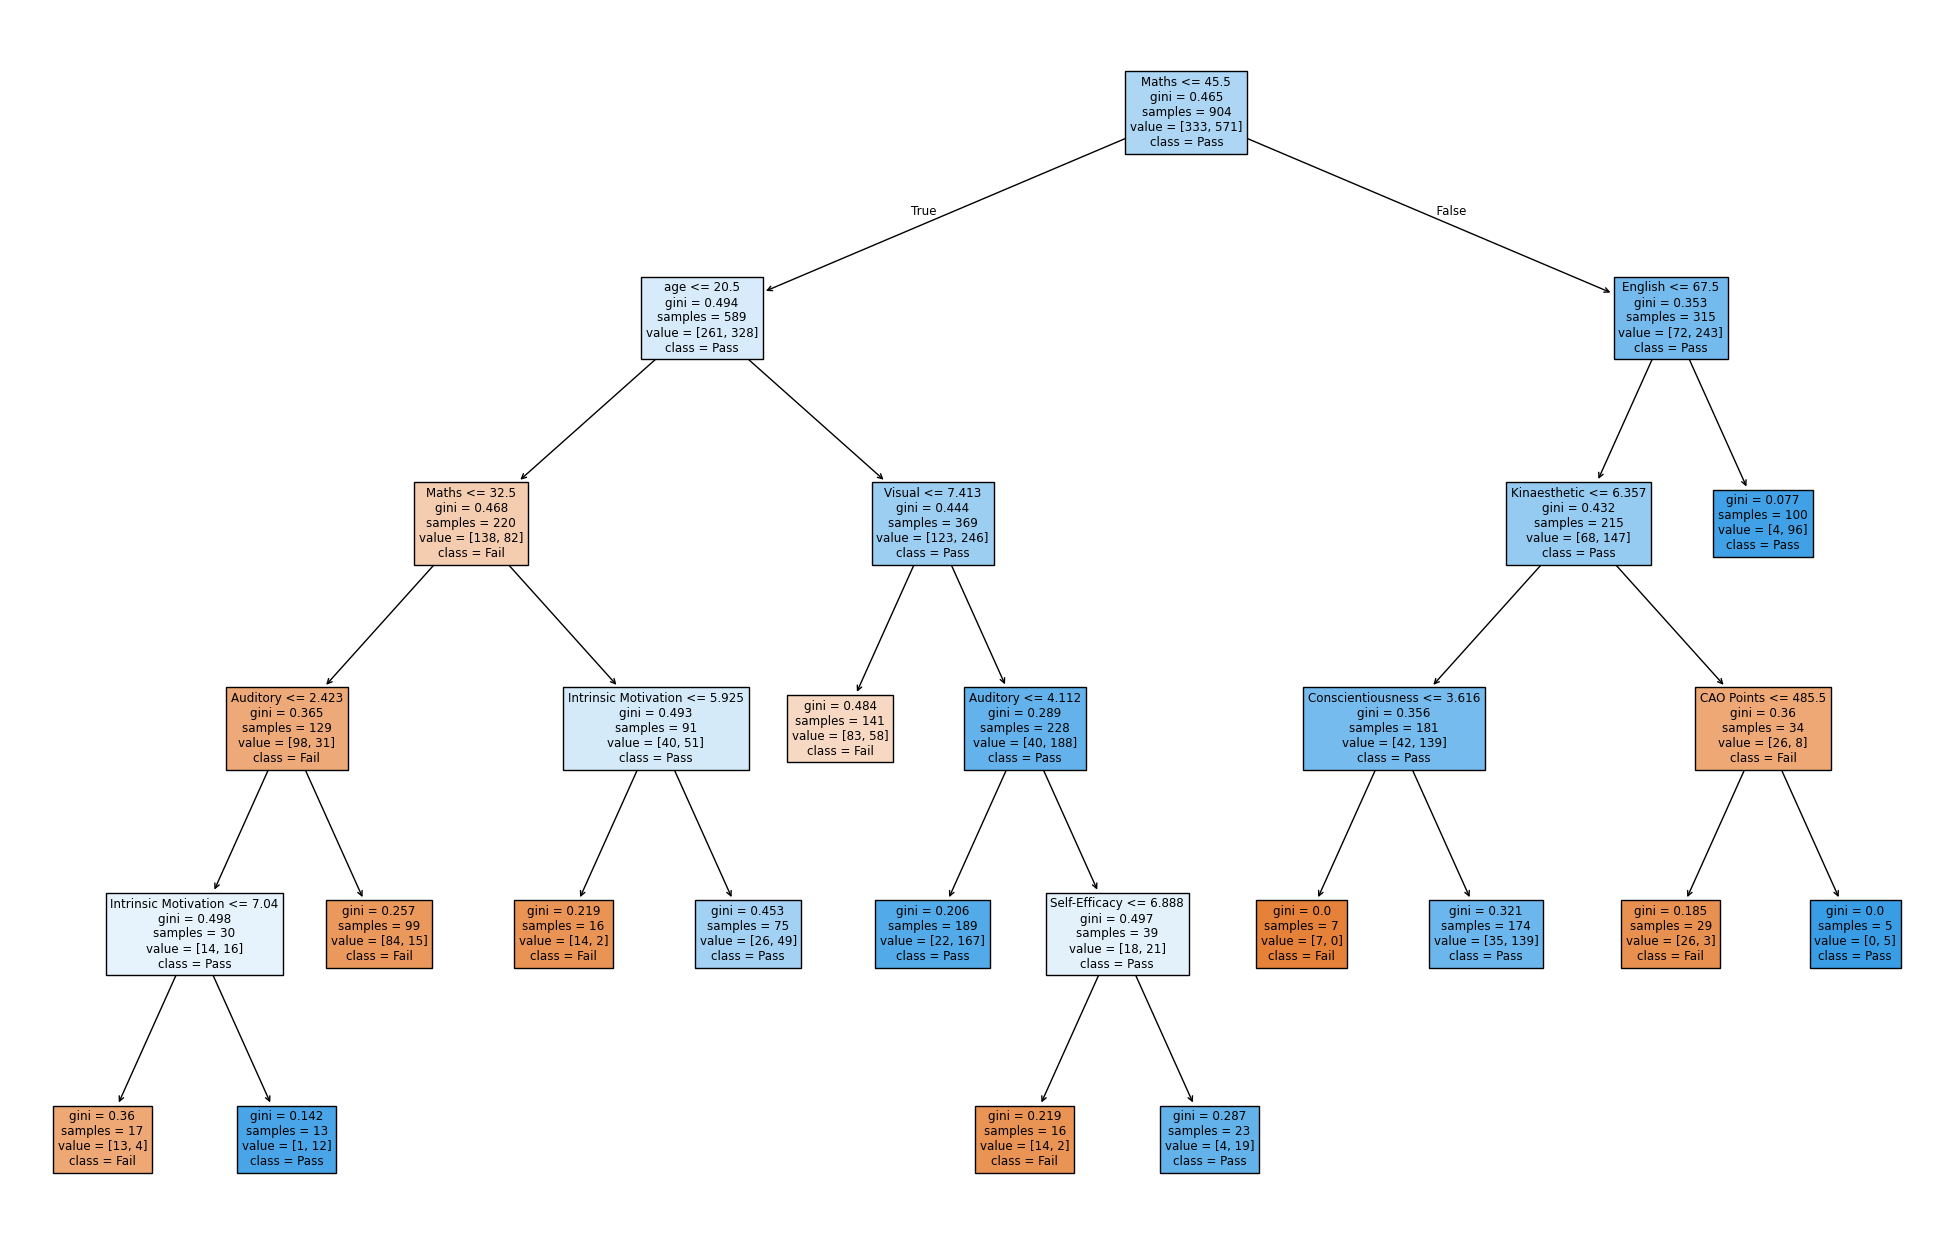

In [ ]:
# postpruning
dt_clf3 = DecisionTreeClassifier(ccp_alpha=0.007,
                                 random_state=43)
ad.custom_crossvalidation(dt_X, y_train, dt_clf3)
dt_clf3.fit(dt_X, y_train)
print(dt_clf3.get_depth(), dt_clf3.get_n_leaves())
plt.figure(figsize=(25, 16))
plot_tree(dt_clf3, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf3.classes_)

In [ ]:
#dt_clf3a = DecisionTreeClassifier(ccp_alpha=0.001,
#                                 random_state=43)
#ad.custom_crossvalidation(dt_X, y_train, dt_clf3a)

for i in np.arange(0.00001, 0.1, 0.0005):
  print(f"ccp_alpha: {i}")
  dt_clf3a = DecisionTreeClassifier(ccp_alpha=i,
                                 random_state=43)
  ad.custom_crossvalidation(dt_X, y_train, dt_clf3a)

#dt_clf3a.fit(dt_X, y_train)
#print(f"Depth: {dt_clf3a.get_depth()} | Nodes: {dt_clf3a.get_n_leaves()}")
#plt.figure(figsize=(25, 16))
#plot_tree(dt_clf3a, filled=True,
#          feature_names=list(dt_X.columns),
#          class_names=dt_clf3a.classes_)

Output hidden; open in https://colab.research.google.com to view.

Text(0, 0.5, 'total impurity of leaves')

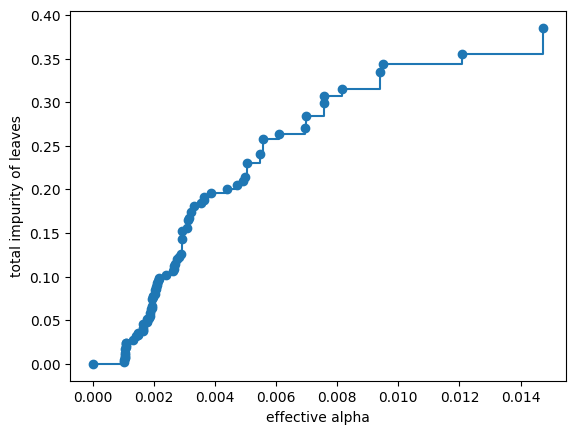

In [ ]:
dt_clf3b = DecisionTreeClassifier(random_state=43)
path = dt_clf3b.cost_complexity_pruning_path(dt_X, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")

#ad.custom_crossvalidation(dt_X, y_train, dt_clf3)
#dt_clf3.fit(dt_X, y_train)
#print(dt_clf3.get_depth(), dt_clf3.get_n_leaves())
#plt.figure(figsize=(25, 16))
#plot_tree(dt_clf3, filled=True,
#          feature_names=list(dt_X.columns),
#          class_names=dt_clf3.classes_)

ccp_alpha: 0.006
Mean accuracy: 74.01% +/-2.05%
Mean precision: 73.04% +/-2.50%
Mean recall: 71.26% +/-2.60%
Mean F1-score is 71.28% +/-2.26%
              precision    recall  f1-score   support

        Fail       0.66      0.61      0.63       333
        Pass       0.78      0.82      0.80       571

    accuracy                           0.74       904
   macro avg       0.72      0.71      0.72       904
weighted avg       0.74      0.74      0.74       904



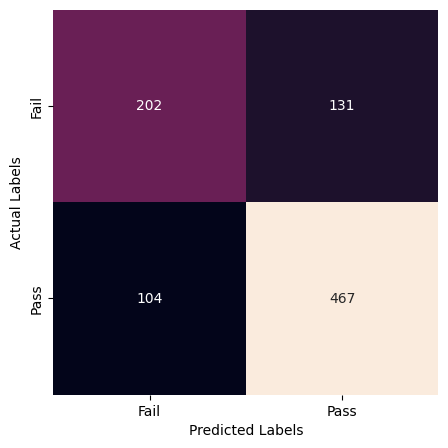

ccp_alpha: 0.007
Mean accuracy: 74.45% +/-1.74%
Mean precision: 73.50% +/-2.47%
Mean recall: 71.73% +/-2.84%
Mean F1-score is 71.75% +/-2.35%
              precision    recall  f1-score   support

        Fail       0.67      0.61      0.64       333
        Pass       0.78      0.82      0.80       571

    accuracy                           0.74       904
   macro avg       0.73      0.72      0.72       904
weighted avg       0.74      0.74      0.74       904



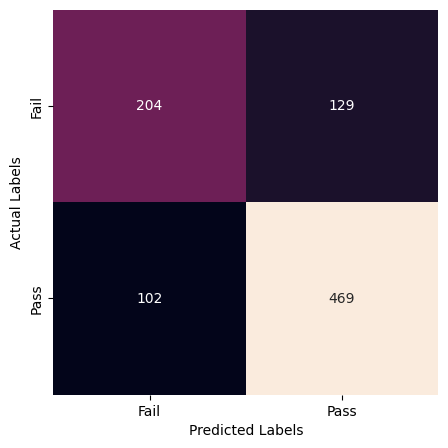

ccp_alpha: 0.008
Mean accuracy: 73.34% +/-1.16%
Mean precision: 71.75% +/-1.24%
Mean recall: 70.48% +/-2.56%
Mean F1-score is 70.59% +/-2.15%
              precision    recall  f1-score   support

        Fail       0.65      0.59      0.62       333
        Pass       0.78      0.81      0.79       571

    accuracy                           0.73       904
   macro avg       0.71      0.70      0.71       904
weighted avg       0.73      0.73      0.73       904



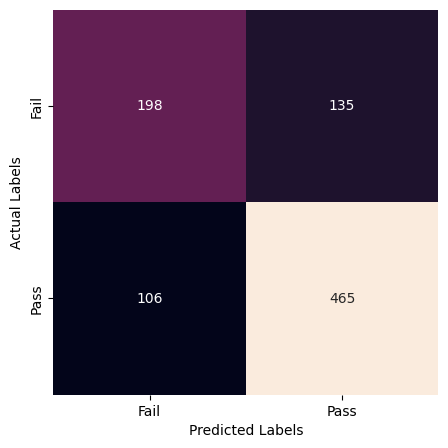

ccp_alpha: 0.009000000000000001
Mean accuracy: 72.13% +/-1.15%
Mean precision: 70.42% +/-1.04%
Mean recall: 68.59% +/-3.18%
Mean F1-score is 68.73% +/-2.75%
              precision    recall  f1-score   support

        Fail       0.64      0.55      0.59       333
        Pass       0.76      0.82      0.79       571

    accuracy                           0.72       904
   macro avg       0.70      0.69      0.69       904
weighted avg       0.72      0.72      0.72       904



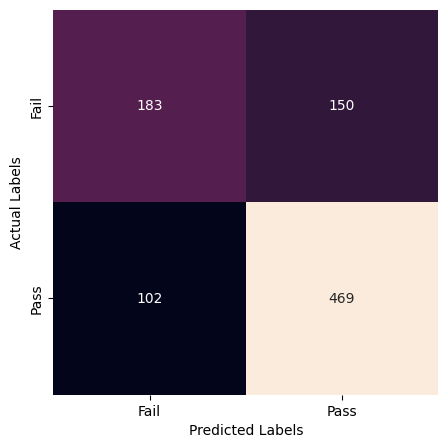

ccp_alpha: 0.01
Mean accuracy: 71.79% +/-0.76%
Mean precision: 70.19% +/-0.51%
Mean recall: 67.89% +/-2.89%
Mean F1-score is 68.06% +/-2.53%
              precision    recall  f1-score   support

        Fail       0.64      0.53      0.58       333
        Pass       0.75      0.83      0.79       571

    accuracy                           0.72       904
   macro avg       0.70      0.68      0.68       904
weighted avg       0.71      0.72      0.71       904



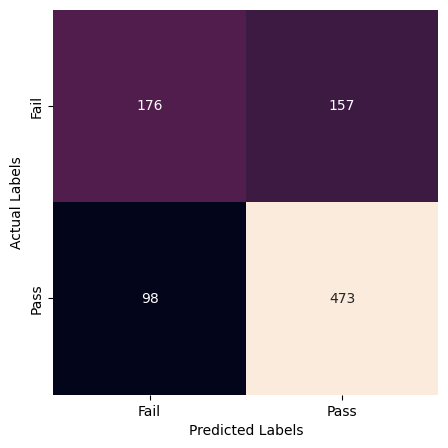

In [ ]:
for i in np.arange(0.006, 0.011, 0.001):
  print(f"ccp_alpha: {i}")
  dt_clf3c = DecisionTreeClassifier(ccp_alpha=i,
                                 random_state=43)
  ad.custom_crossvalidation(dt_X, y_train, dt_clf3c)

Mean accuracy: 74.45% +/-1.74%
Mean precision: 73.50% +/-2.47%
Mean recall: 71.73% +/-2.84%
Mean F1-score is 71.75% +/-2.35%
              precision    recall  f1-score   support

        Fail       0.67      0.61      0.64       333
        Pass       0.78      0.82      0.80       571

    accuracy                           0.74       904
   macro avg       0.73      0.72      0.72       904
weighted avg       0.74      0.74      0.74       904



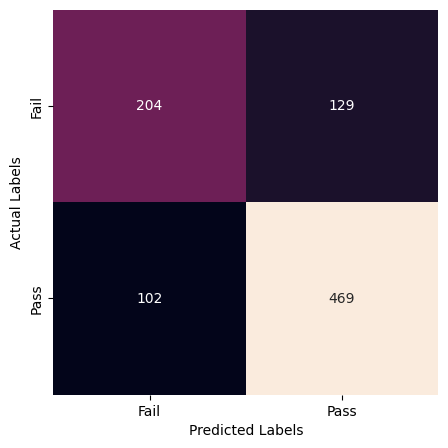

5 14


[Text(0.6071428571428571, 0.9166666666666666, 'Maths <= 45.5\ngini = 0.465\nsamples = 904\nvalue = [333, 571]\nclass = Pass'),
 Text(0.35714285714285715, 0.75, 'age <= 20.5\ngini = 0.494\nsamples = 589\nvalue = [261, 328]\nclass = Pass'),
 Text(0.4821428571428571, 0.8333333333333333, 'True  '),
 Text(0.23809523809523808, 0.5833333333333334, 'Maths <= 32.5\ngini = 0.468\nsamples = 220\nvalue = [138, 82]\nclass = Fail'),
 Text(0.14285714285714285, 0.4166666666666667, 'Auditory <= 2.423\ngini = 0.365\nsamples = 129\nvalue = [98, 31]\nclass = Fail'),
 Text(0.09523809523809523, 0.25, 'Intrinsic Motivation <= 7.04\ngini = 0.498\nsamples = 30\nvalue = [14, 16]\nclass = Pass'),
 Text(0.047619047619047616, 0.08333333333333333, 'gini = 0.36\nsamples = 17\nvalue = [13, 4]\nclass = Fail'),
 Text(0.14285714285714285, 0.08333333333333333, 'gini = 0.142\nsamples = 13\nvalue = [1, 12]\nclass = Pass'),
 Text(0.19047619047619047, 0.25, 'gini = 0.257\nsamples = 99\nvalue = [84, 15]\nclass = Fail'),
 Text

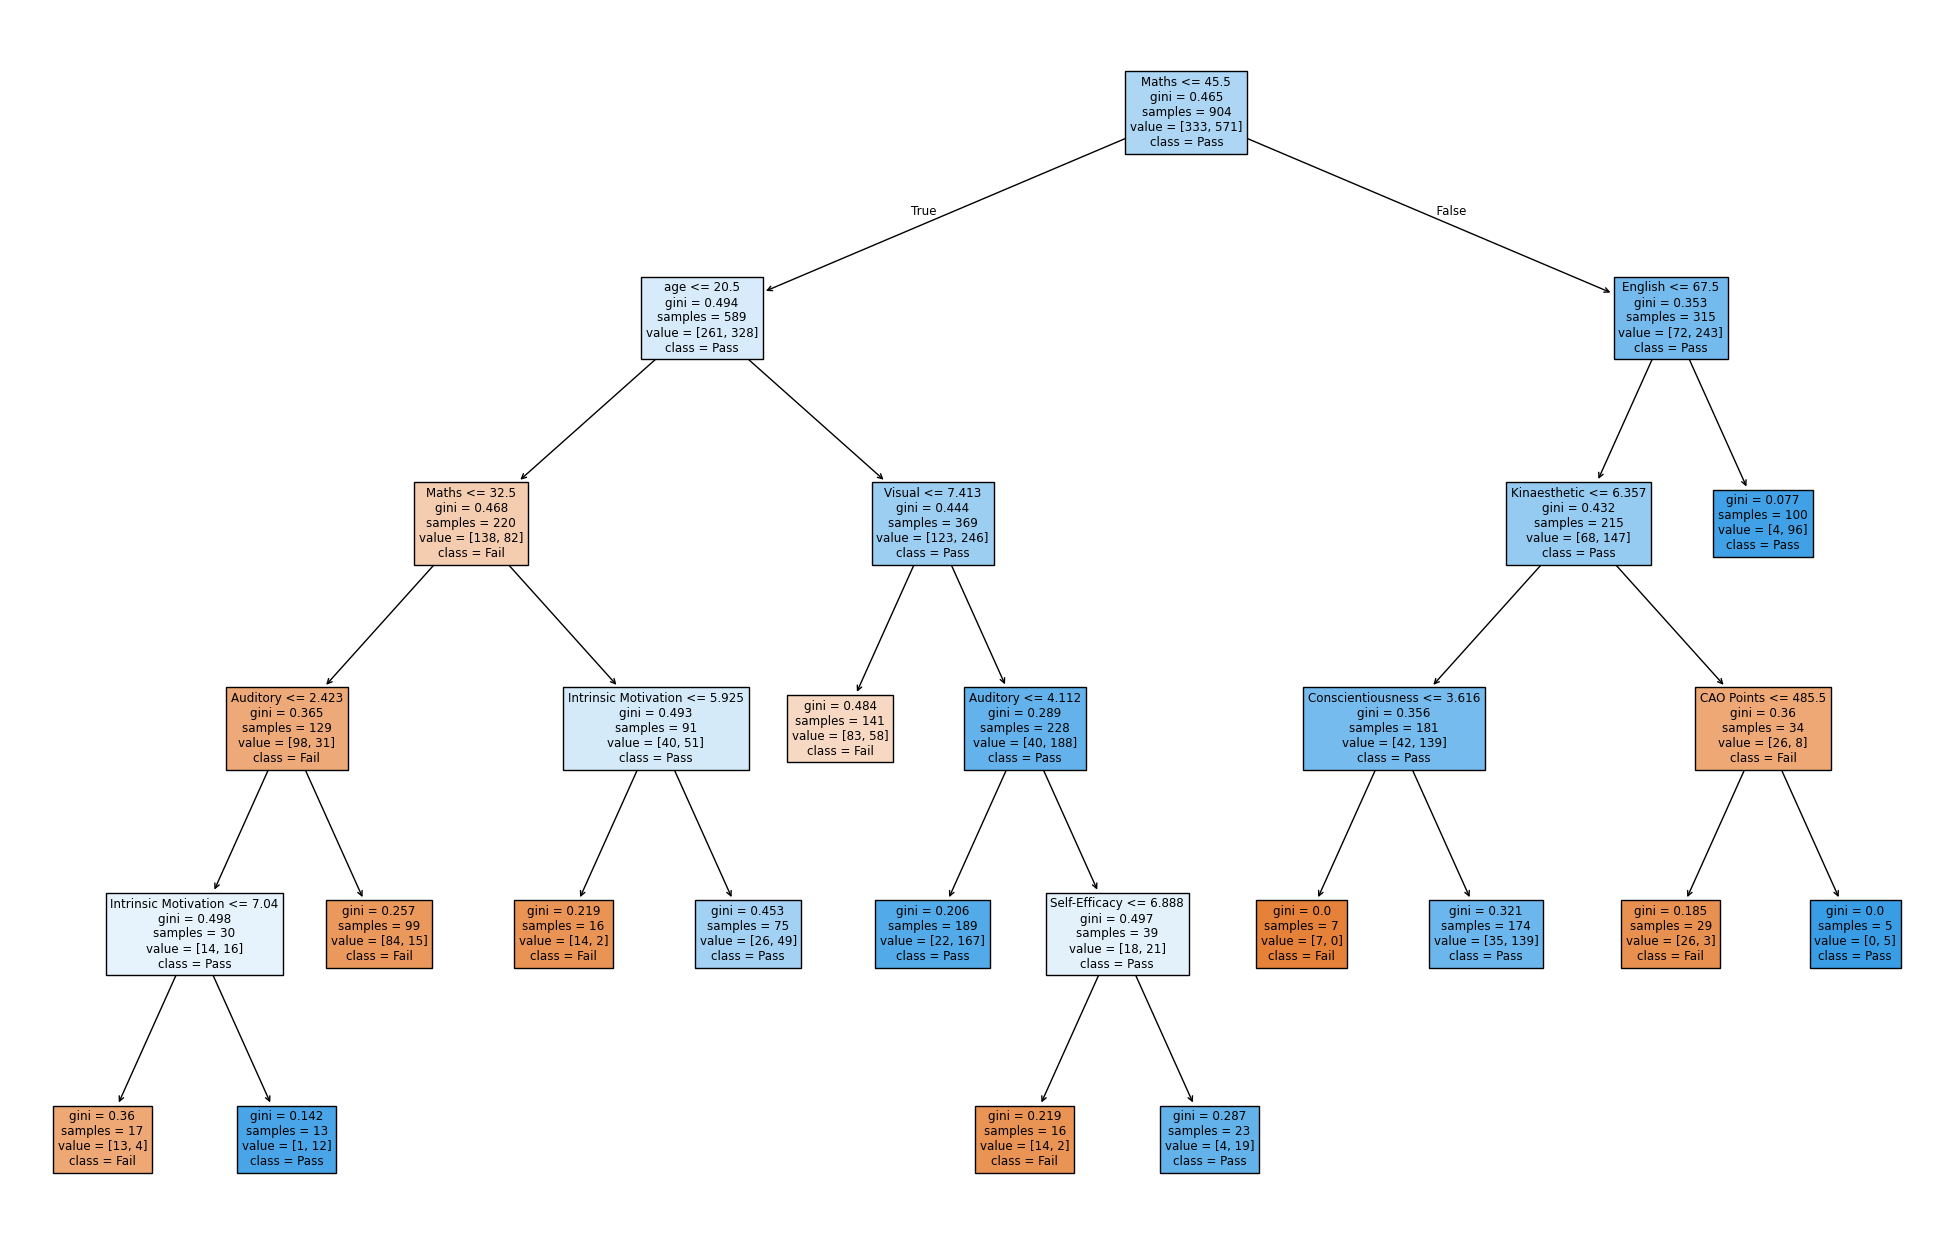

In [ ]:
dt_clf3b = DecisionTreeClassifier(ccp_alpha=0.007, random_state=43)
path = dt_clf3b.cost_complexity_pruning_path(dt_X, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ad.custom_crossvalidation(dt_X, y_train, dt_clf3b)
dt_clf3b.fit(dt_X, y_train)
print(dt_clf3b.get_depth(), dt_clf3b.get_n_leaves())
plt.figure(figsize=(25, 16))
plot_tree(dt_clf3b, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf3b.classes_)

Mean accuracy: 74.23% +/-1.66%
Mean precision: 73.26% +/-2.50%
Mean recall: 71.43% +/-2.76%
Mean F1-score is 71.46% +/-2.22%
              precision    recall  f1-score   support

        Fail       0.66      0.61      0.63       333
        Pass       0.78      0.82      0.80       571

    accuracy                           0.74       904
   macro avg       0.72      0.71      0.72       904
weighted avg       0.74      0.74      0.74       904



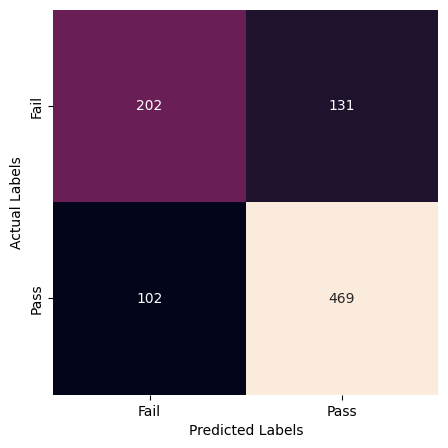

5 14


[Text(0.6071428571428571, 0.9166666666666666, 'Maths <= 45.5\ngini = 0.465\nsamples = 904\nvalue = [333, 571]\nclass = Pass'),
 Text(0.35714285714285715, 0.75, 'age <= 20.5\ngini = 0.494\nsamples = 589\nvalue = [261, 328]\nclass = Pass'),
 Text(0.4821428571428571, 0.8333333333333333, 'True  '),
 Text(0.23809523809523808, 0.5833333333333334, 'Maths <= 32.5\ngini = 0.468\nsamples = 220\nvalue = [138, 82]\nclass = Fail'),
 Text(0.14285714285714285, 0.4166666666666667, 'Auditory <= 2.423\ngini = 0.365\nsamples = 129\nvalue = [98, 31]\nclass = Fail'),
 Text(0.09523809523809523, 0.25, 'Intrinsic Motivation <= 7.04\ngini = 0.498\nsamples = 30\nvalue = [14, 16]\nclass = Pass'),
 Text(0.047619047619047616, 0.08333333333333333, 'gini = 0.36\nsamples = 17\nvalue = [13, 4]\nclass = Fail'),
 Text(0.14285714285714285, 0.08333333333333333, 'gini = 0.142\nsamples = 13\nvalue = [1, 12]\nclass = Pass'),
 Text(0.19047619047619047, 0.25, 'gini = 0.257\nsamples = 99\nvalue = [84, 15]\nclass = Fail'),
 Text

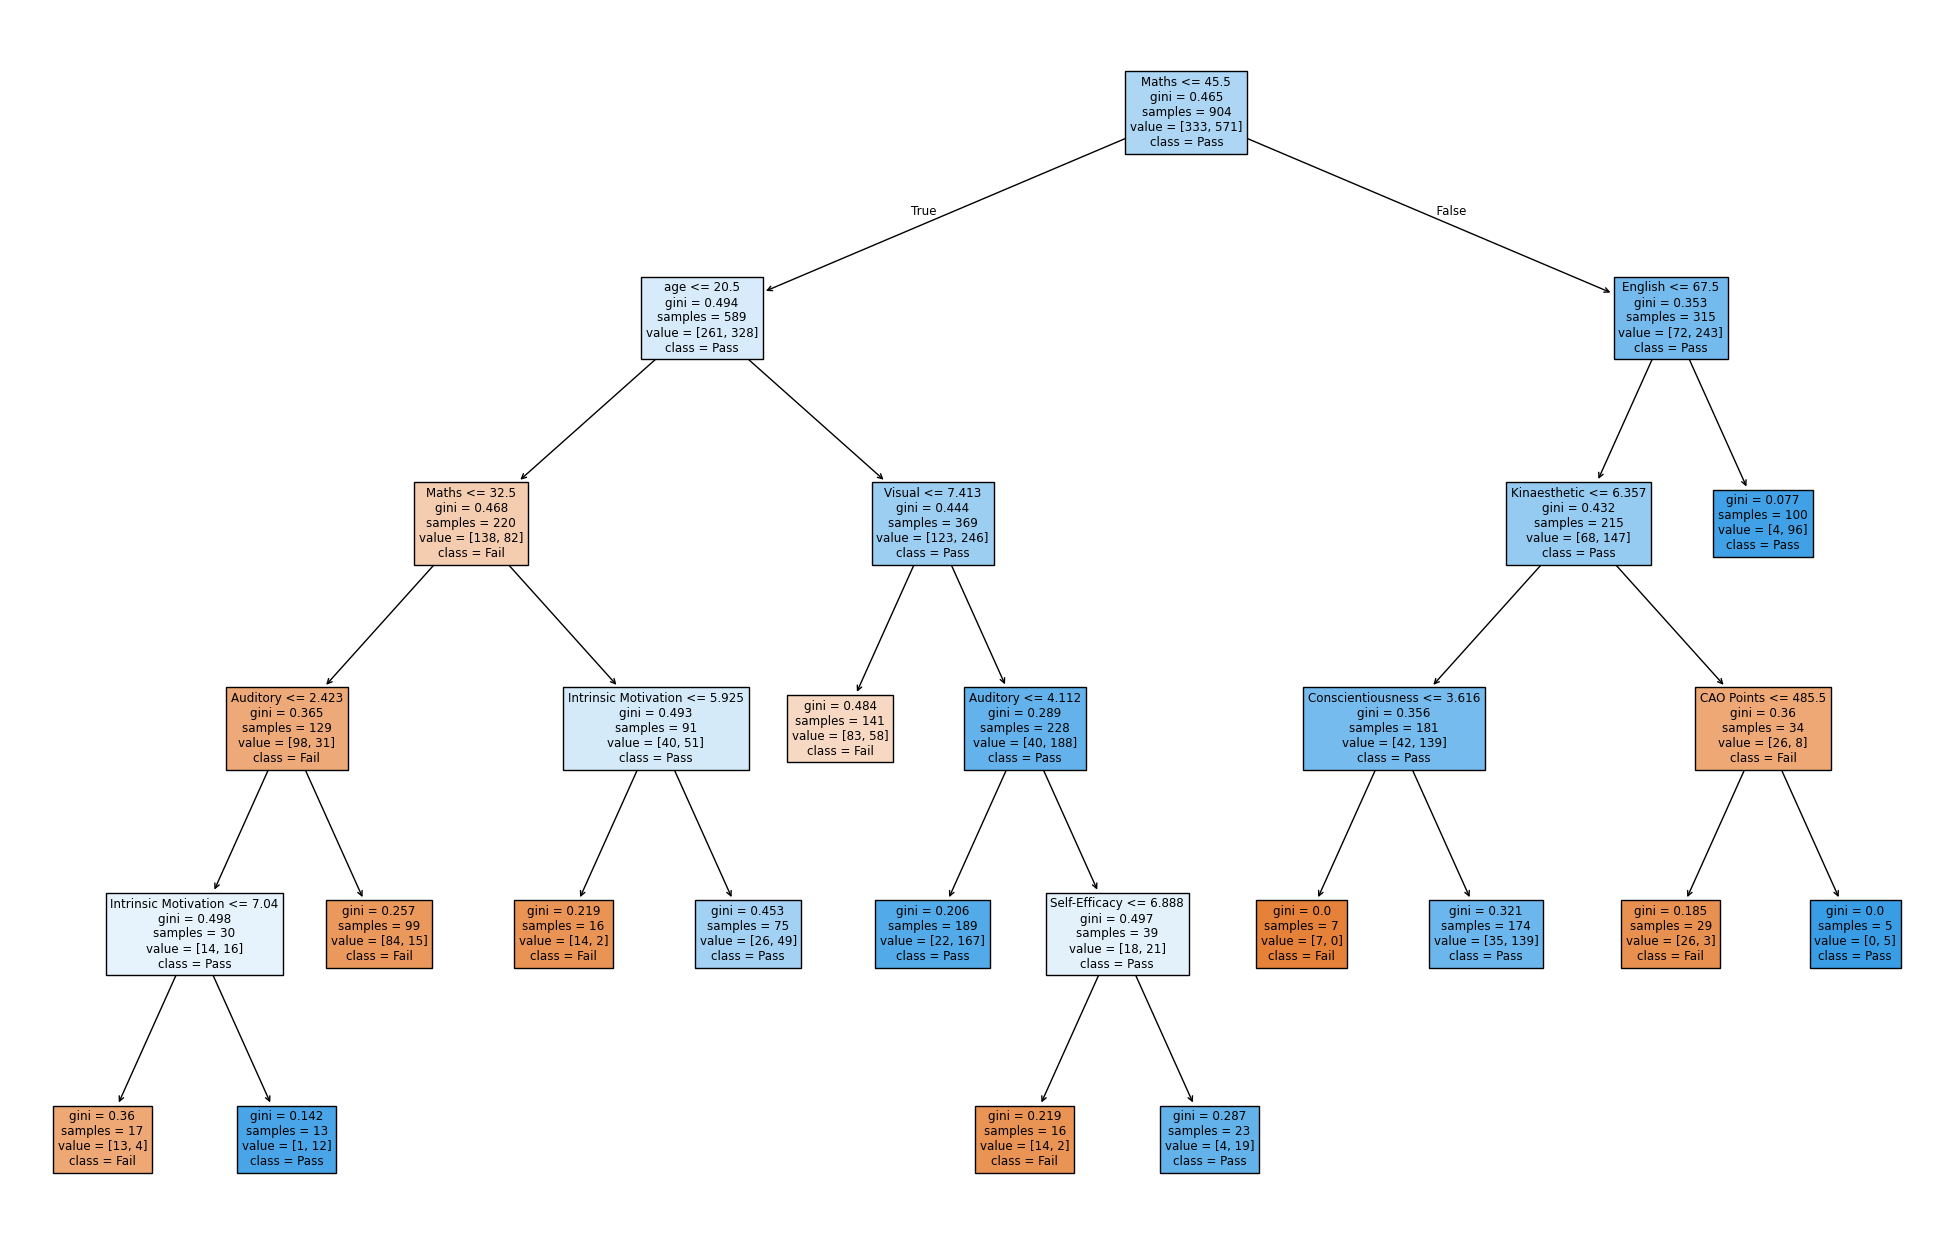

In [ ]:
# combine pre- and post-pruning
dt_clf4 = DecisionTreeClassifier(max_depth=10, min_samples_split=5,
                                min_samples_leaf=3, ccp_alpha=0.007,
                                 random_state=43)
ad.custom_crossvalidation(dt_X, y_train, dt_clf4)
dt_clf4.fit(dt_X, y_train)
print(dt_clf4.get_depth(), dt_clf4.get_n_leaves())
plt.figure(figsize=(25, 16))
plot_tree(dt_clf4, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf4.classes_)

### Find Optimal Model using a grid search
- optimise for f-measure rather than accuracy, given the class imbalance.

In [10]:
dt_clf5 = DecisionTreeClassifier(random_state=43)

params = {
    #'criterion' : ['gini', 'entropy'],
    'max_depth': range(4, 11),
    'min_impurity_decrease' : np.arange(0.01, 0.3, 0.01),
    'min_samples_leaf': range(2, 20, 4),
    'min_samples_split': range(2, 12, 2),
    'ccp_alpha': [0.006, 0.007, 0.008, 0.009]
}
grid_search = GridSearchCV(dt_clf5, param_grid=params, scoring='f1_macro')
grid_search.fit(dt_X, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'ccp_alpha': 0.006, 'max_depth': 5, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.6314106643334318


In [11]:
(np.mean(grid_search.cv_results_['mean_test_score']),
np.std(grid_search.cv_results_['mean_test_score']))

(0.3991874161852996, 0.04708292804452753)

### Test the optimal model on the training portion

Mean accuracy: 70.58% +/-2.82%
Mean precision: 72.80% +/-4.73%
Mean recall: 64.57% +/-6.36%
Mean F1-score is 63.14% +/-9.46%
              precision    recall  f1-score   support

        Fail       0.66      0.41      0.51       333
        Pass       0.72      0.88      0.79       571

    accuracy                           0.71       904
   macro avg       0.69      0.65      0.65       904
weighted avg       0.70      0.71      0.69       904



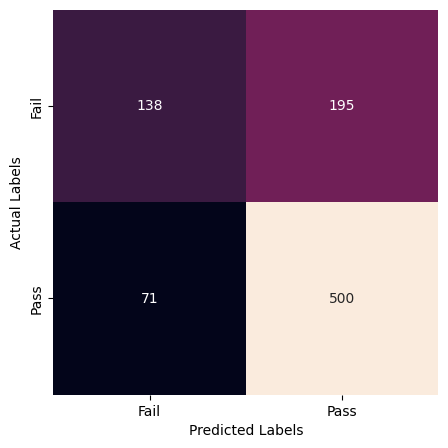

3 7


[Text(0.5769230769230769, 0.875, 'Maths <= 45.5\ngini = 0.465\nsamples = 904\nvalue = [333, 571]\nclass = Pass'),
 Text(0.3076923076923077, 0.625, 'age <= 20.5\ngini = 0.494\nsamples = 589\nvalue = [261, 328]\nclass = Pass'),
 Text(0.4423076923076923, 0.75, 'True  '),
 Text(0.15384615384615385, 0.375, 'Maths <= 32.5\ngini = 0.468\nsamples = 220\nvalue = [138, 82]\nclass = Fail'),
 Text(0.07692307692307693, 0.125, 'gini = 0.365\nsamples = 129\nvalue = [98, 31]\nclass = Fail'),
 Text(0.23076923076923078, 0.125, 'gini = 0.493\nsamples = 91\nvalue = [40, 51]\nclass = Pass'),
 Text(0.46153846153846156, 0.375, 'Visual <= 7.413\ngini = 0.444\nsamples = 369\nvalue = [123, 246]\nclass = Pass'),
 Text(0.38461538461538464, 0.125, 'gini = 0.484\nsamples = 141\nvalue = [83, 58]\nclass = Fail'),
 Text(0.5384615384615384, 0.125, 'gini = 0.289\nsamples = 228\nvalue = [40, 188]\nclass = Pass'),
 Text(0.8461538461538461, 0.625, 'English <= 67.5\ngini = 0.353\nsamples = 315\nvalue = [72, 243]\nclass = Pa

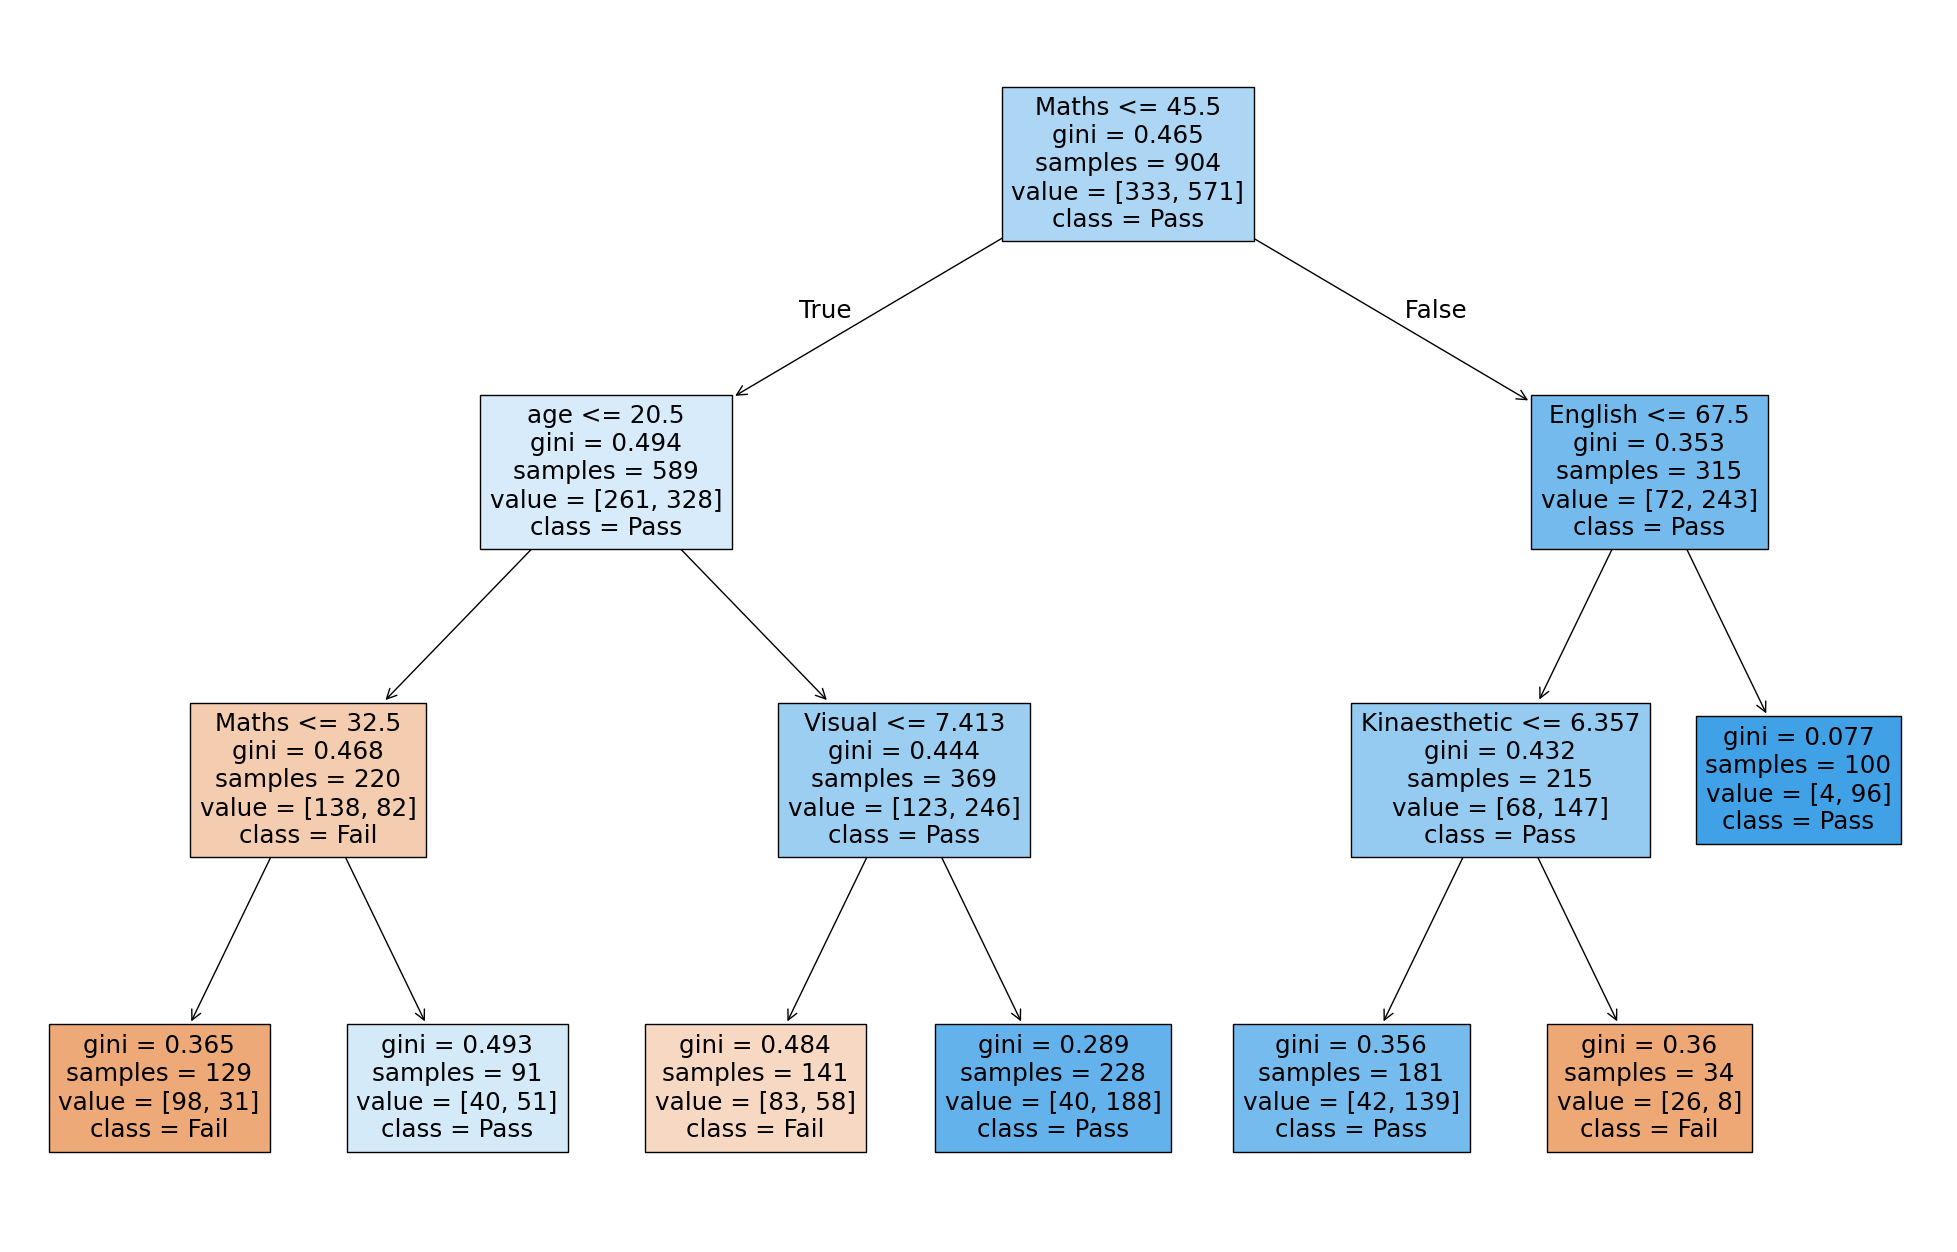

In [14]:
dt_clf5a = DecisionTreeClassifier(criterion = 'gini', max_depth=5, min_impurity_decrease=0.01,
                                min_samples_leaf=2, min_samples_split=2, ccp_alpha=0.006,
                                 random_state=43)
path = dt_clf5a.cost_complexity_pruning_path(dt_X, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ad.custom_crossvalidation(dt_X, y_train, dt_clf5a)
dt_clf5a.fit(dt_X, y_train)
print(dt_clf5a.get_depth(), dt_clf5a.get_n_leaves())
plt.figure(figsize=(25, 16))
plot_tree(dt_clf5a, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf5a.classes_)

### Test the optimal model on the testing portion
- we will use a pipeline
- part of the pipeline is encoding the DT modelling

              precision    recall  f1-score   support

        Fail       0.52      0.63      0.57        87
        Pass       0.74      0.64      0.69       140

    accuracy                           0.64       227
   macro avg       0.63      0.64      0.63       227
weighted avg       0.66      0.64      0.64       227



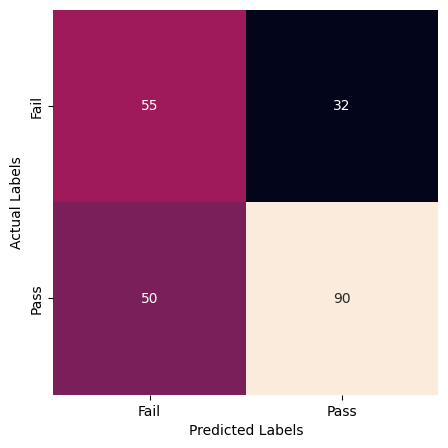

[Text(0.5769230769230769, 0.875, 'x[7] <= 45.5\ngini = 0.465\nsamples = 904\nvalue = [333, 571]'),
 Text(0.3076923076923077, 0.625, 'x[11] <= 2.5\ngini = 0.494\nsamples = 589\nvalue = [261, 328]'),
 Text(0.4423076923076923, 0.75, 'True  '),
 Text(0.15384615384615385, 0.375, 'x[7] <= 32.5\ngini = 0.468\nsamples = 220\nvalue = [138, 82]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.365\nsamples = 129\nvalue = [98, 31]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.493\nsamples = 91\nvalue = [40, 51]'),
 Text(0.46153846153846156, 0.375, 'x[10] <= 305.5\ngini = 0.444\nsamples = 369\nvalue = [123, 246]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.484\nsamples = 141\nvalue = [83, 58]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.289\nsamples = 228\nvalue = [40, 188]'),
 Text(0.8461538461538461, 0.625, 'x[3] <= 67.5\ngini = 0.353\nsamples = 315\nvalue = [72, 243]'),
 Text(0.7115384615384615, 0.75, '  False'),
 Text(0.7692307692307693, 0.375, 'x[6] <= 505.5\ngini = 0.432\nsamples = 215\nval

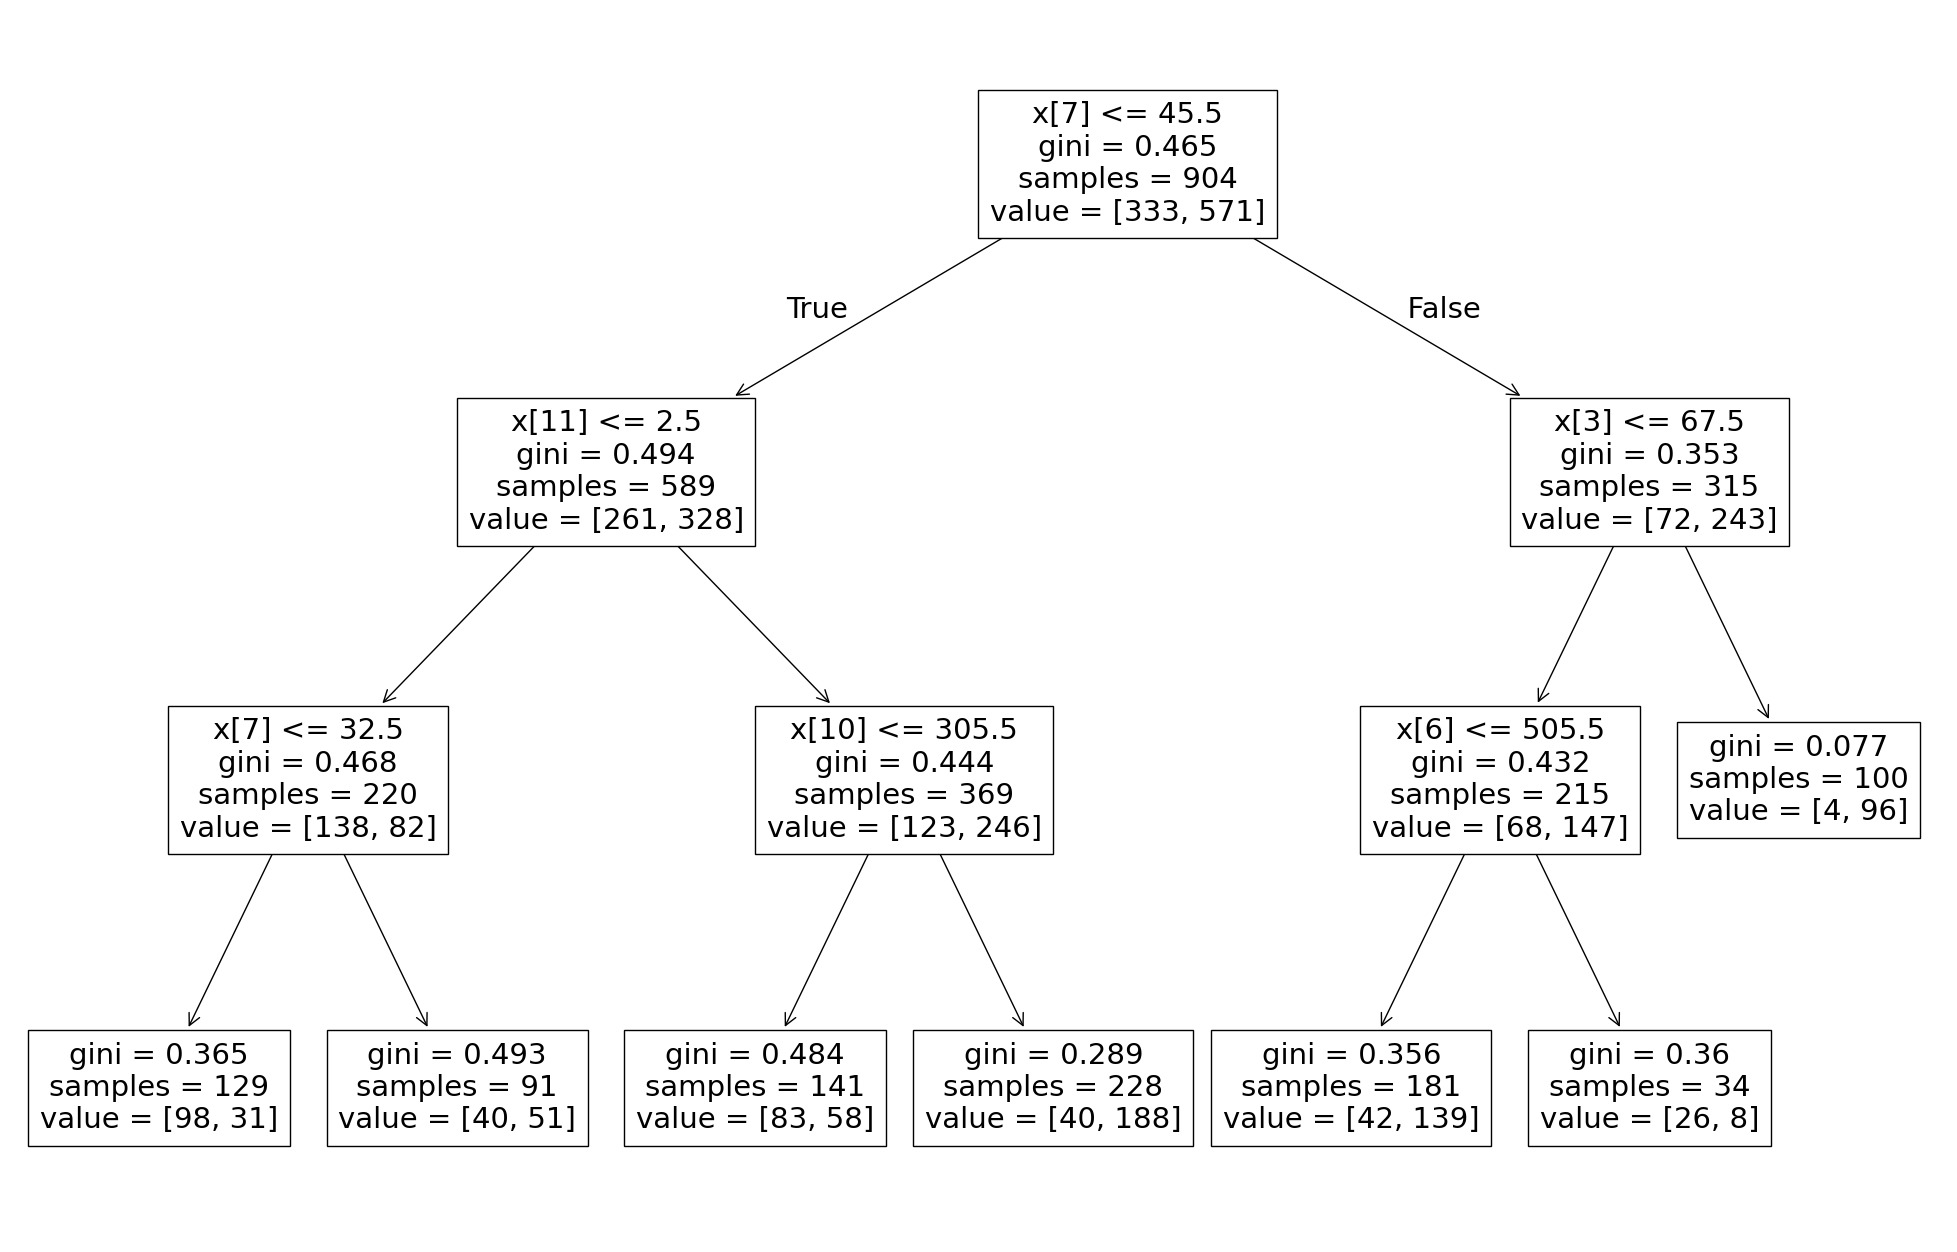

In [19]:
pipeline = Pipeline([
    # unknown categories are handled by mapping them to -1
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('sklearn_dt', grid_search.best_estimator_)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
ad.plot_confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(25, 16))
plot_tree(pipeline['sklearn_dt'])


In [ ]:
plt.figure(figsize=(25, 16))
plot_tree(dt_clf5a, filled=True,
          feature_names=list(dt_X.columns),
          class_names=dt_clf5a.classes_)

### Scoring
- assuming we are happy with the optimal model (we shouldn't really!) we can use it for predicting labels of new rows of data without a label (e.g., can deploy the model for a real application)

In [ ]:
new_rows = pd.DataFrame(
          np.array([
                    [45, 'm', 'monthly', 37000, 2, 'single', 'y', 2, 0, 1],
                    [25, 'f', 'monthly', 34000, 1, 'single', 'n', 1, 0, 1],
                    [60, 'm', 'monthly', 25000, 0, 'married', 'y', 0, 0, 1],
                  ]),
          columns=X_train.columns
)
pipeline.predict(new_rows)

array(['bad profit', 'bad profit', 'bad profit'], dtype=object)

## Decision Tree Using XGBOOST

### Necessary Preparation
- accepts categorical data, however, it needs to be specifically 'category'
- the class label column must be an integer, therefore we can apply the label encoder or just simply the function map

In [ ]:
# convert object columns specifically to 'category'
xgb_X = X.copy()
object_cols = xgb_X.select_dtypes(include='object').columns
xgb_X[object_cols] = xgb_X[object_cols].astype('category')
# encode label column using the LabelEncoder class
# y_enc = y.apply(LabelEncoder().fit_transform)
# encode label column using the map function
y_enc = y['Pass'].map({'Pass': 0, 'Fail': 1})
xgb_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Auditory              1131 non-null   float64
 1   CAO Points            1131 non-null   float64
 2   Conscientiousness     1131 non-null   float64
 3   English               1131 non-null   float64
 4   Extrinsic Motivation  1131 non-null   float64
 5   Intrinsic Motivation  1131 non-null   float64
 6   Kinaesthetic          1131 non-null   float64
 7   Maths                 1131 non-null   float64
 8   Self-Efficacy         1131 non-null   float64
 9   Study Time            1131 non-null   float64
 10  Visual                1131 non-null   float64
 11  age                   1131 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 106.2 KB


In [ ]:
y_enc.value_counts()

,count
RISK,
1,292
0,110
2,98


In [ ]:
# split the data
xgb_X_train, xgb_X_test, y_train, y_test = train_test_split(
    xgb_X, y_enc, test_size=0.2, random_state=43
)

### xgb tree baseline model

Mean accuracy: 72.75% +/-5.61%
Mean precision: 68.27% +/-6.66%
Mean recall: 67.41% +/-7.01%
Mean F1-score is 67.42% +/-6.81%
              precision    recall  f1-score   support

           0       0.60      0.52      0.56        92
           1       0.80      0.83      0.81       231
           2       0.63      0.68      0.65        77

    accuracy                           0.73       400
   macro avg       0.68      0.67      0.68       400
weighted avg       0.72      0.73      0.72       400



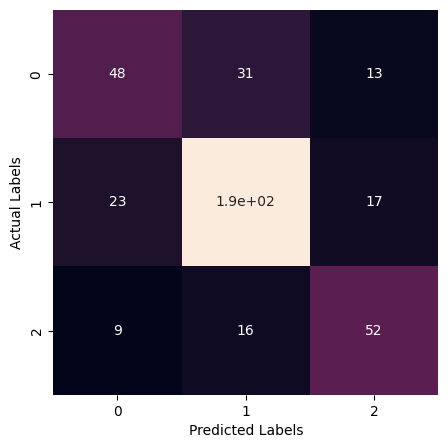

In [ ]:
# simulate a single decision tree; leave other hyperparameters to default values
xgb_dt = XGBClassifier(enable_categorical=True, n_estimators=1, num_parallel_tree=1,
           objective='multi: softmax', num_class=3, random_state=43)
# crossvalidate and output performance
ad.custom_crossvalidation(xgb_X_train, y_train, xgb_dt)

In [ ]:
xgb_dt.fit(xgb_X_train, y_train)
tree_text = xgb_dt.get_booster().get_dump(with_stats=True)
# Print the decision rules for the first tree
print(tree_text[0])

0:[STORECAR<4] yes=1,no=2,missing=2,gain=38.466713,cover=177.777771
	1:[AGE<44] yes=3,no=4,missing=4,gain=2.39994431,cover=134.666656
		3:[NUMKIDS<4] yes=7,no=8,missing=8,gain=0.385005951,cover=123.111107
			7:[INCOME<33911] yes=13,no=14,missing=14,gain=0.289100647,cover=121.777771
				13:[AGE<23] yes=23,no=24,missing=24,gain=0.737098694,cover=97.777771
					23:[INCOME<22584] yes=37,no=38,missing=38,gain=0.435663223,cover=40.4444427
						37:leaf=-0.100429207,cover=24.8888874
						38:leaf=-0.175167814,cover=15.5555544
					24:leaf=-0.195428595,cover=57.3333282
				14:[INCOME<40782] yes=25,no=26,missing=26,gain=3.53867006,cover=23.9999981
					25:[STORECAR<2] yes=39,no=40,missing=40,gain=0.623376727,cover=2.66666651
						39:leaf=-7.66345476e-09,cover=1.33333325
						40:leaf=0.257142842,cover=1.33333325
					26:[GENDER:{0}] yes=42,no=41,missing=41,gain=0.203402042,cover=21.3333321
						41:leaf=-0.18837212,cover=13.3333321
						42:leaf=-0.100000016,cover=7.99999952
			8:leaf=-7.66345

In [ ]:
print(tree_text[1])

0:[AGE<29] yes=1,no=2,missing=2,gain=54.6224022,cover=177.777771
	1:[STORECAR<5] yes=3,no=4,missing=4,gain=6.43131256,cover=75.9999924
		3:[INCOME<24944] yes=7,no=8,missing=8,gain=0.881599426,cover=74.2222214
			7:[NUMCARDS<6] yes=13,no=14,missing=14,gain=0.0261764526,cover=70.6666641
				13:leaf=0.37962085,cover=69.3333282
				14:leaf=0.128571421,cover=1.33333325
			8:[INCOME<32526] yes=15,no=16,missing=16,gain=1.4048779,cover=3.55555534
				15:leaf=-0.0360000096,cover=1.77777767
				16:leaf=0.288000017,cover=1.77777767
		4:leaf=-0.144000009,cover=1.77777767
	2:[INCOME<24512] yes=5,no=6,missing=6,gain=10.365242,cover=101.777771
		5:[AGE<42] yes=9,no=10,missing=10,gain=9.68804932,cover=42.6666641
			9:[INCOME<18651] yes=17,no=18,missing=18,gain=2.36596298,cover=21.3333321
				17:[NUMKIDS<2] yes=25,no=26,missing=26,gain=3.01472759,cover=4.88888836
					25:leaf=0.24545455,cover=2.66666651
					26:leaf=-0.155172437,cover=2.22222209
				18:[AGE<32] yes=27,no=28,missing=28,gain=0.428598404,

In [ ]:
print(tree_text[2])

0:[INCOME<29912] yes=1,no=2,missing=2,gain=45.9351501,cover=177.777771
	1:[LOANS<1] yes=3,no=4,missing=4,gain=10.971859,cover=144.444443
		3:[AGE<37] yes=7,no=8,missing=8,gain=0.523636103,cover=4.44444418
			7:leaf=0.327272743,cover=2.66666651
			8:leaf=0.0719999969,cover=1.77777767
		4:[MARITAL:{0}] yes=10,no=9,missing=9,gain=3.21516037,cover=139.999985
			9:leaf=-0.211135164,cover=101.777771
			10:[AGE<34] yes=13,no=14,missing=14,gain=2.30229616,cover=38.2222214
				13:[MORTGAGE:{0}] yes=20,no=19,missing=19,gain=4.00212193,cover=6.22222185
					19:leaf=0.310344815,cover=2.22222209
					20:[INCOME<18450] yes=27,no=28,missing=28,gain=0.290909171,cover=3.99999976
						27:leaf=-7.66345476e-09,cover=1.33333325
						28:leaf=-0.163636371,cover=2.66666651
				14:[NUMKIDS<4] yes=21,no=22,missing=22,gain=0.49353075,cover=31.9999981
					21:[AGE<45] yes=29,no=30,missing=30,gain=0.875165939,cover=21.7777767
						29:leaf=-0.0741176605,cover=8.4444437
						30:leaf=-0.209302351,cover=13.3333321

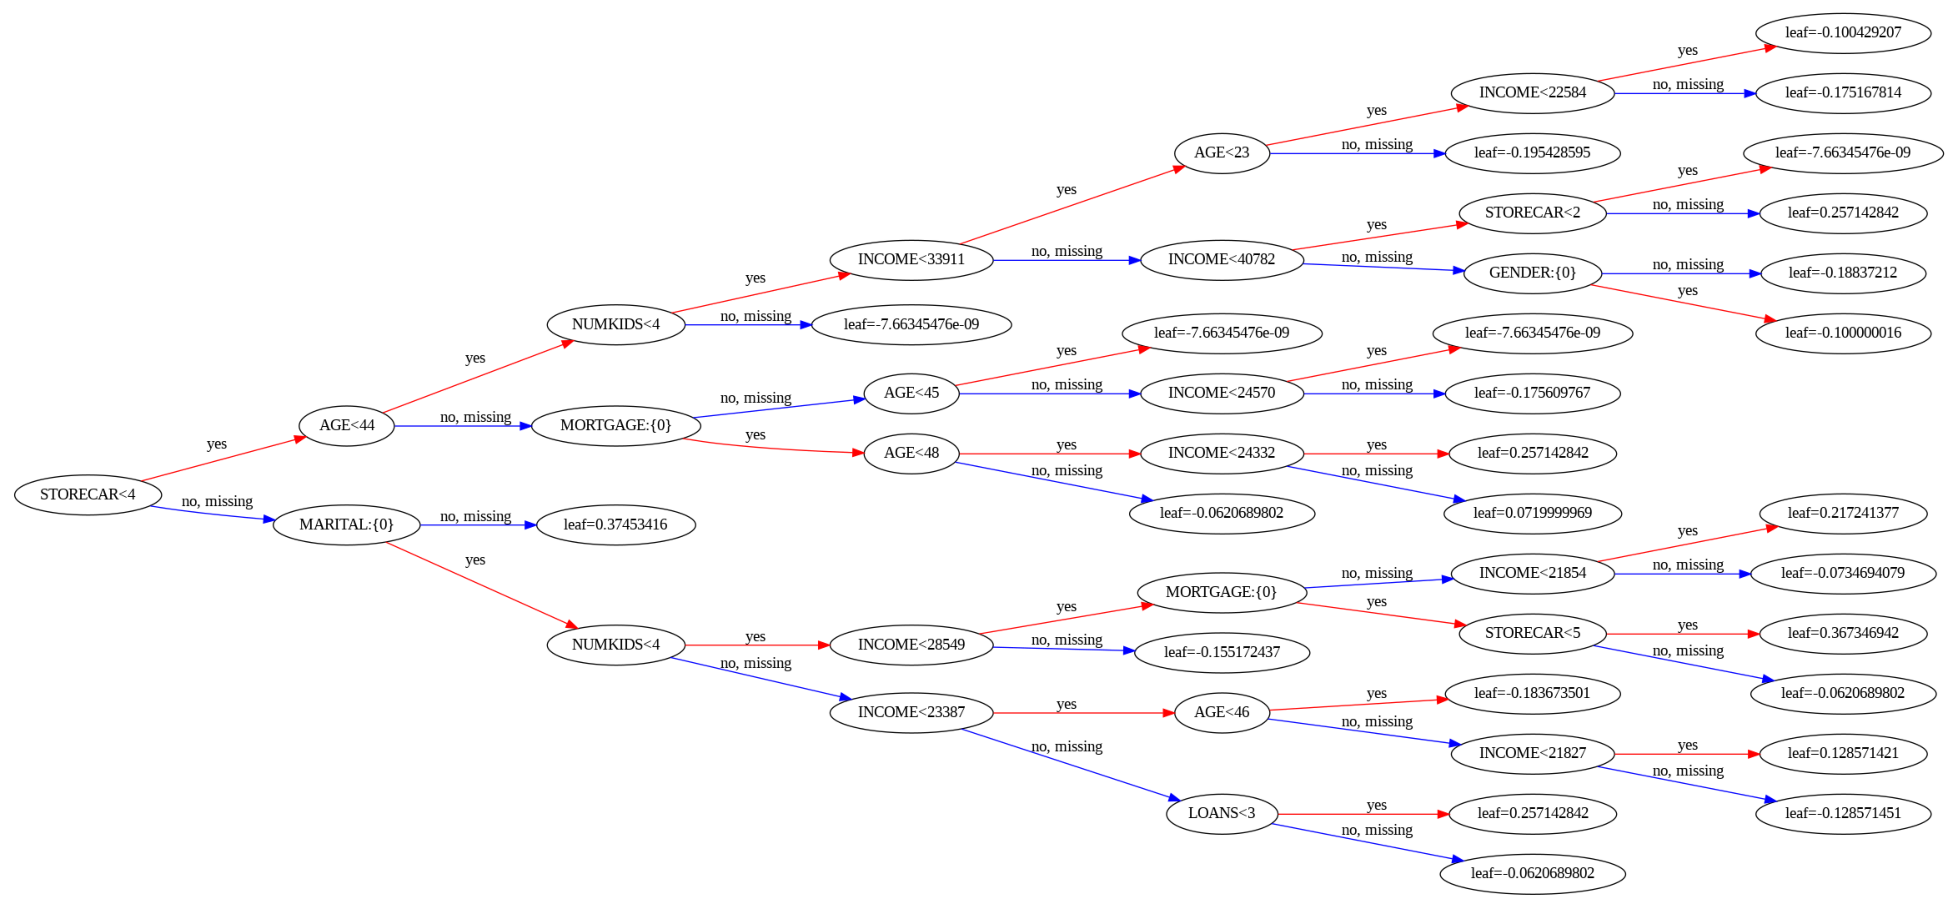

In [ ]:
fig = plt.figure(figsize=(25, 16))
ax = fig.gca()
# num_trees specifies the index of the tree to plot
xgb.plot_tree(xgb_dt, num_trees=0, rankdir='LR', ax=ax)
plt.show()

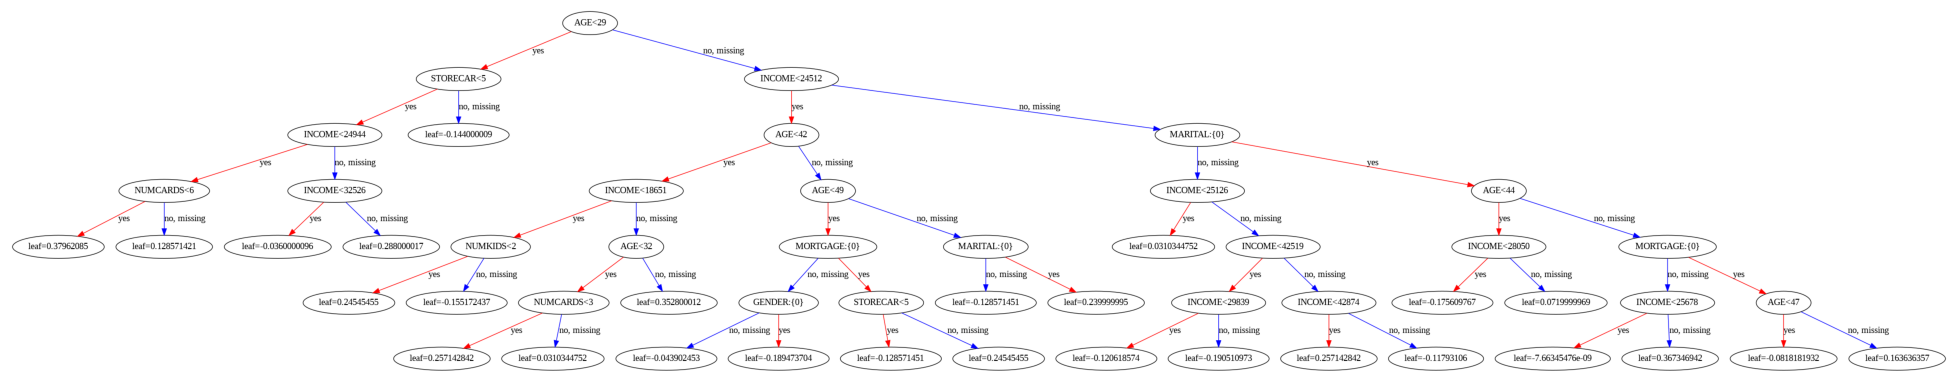

In [ ]:
fig = plt.figure(figsize=(25, 16))
ax = fig.gca()
# num_trees specifies the index of the tree to plot
xgb.plot_tree(xgb_dt, num_trees=1, ax=ax)
plt.show()

### Optimisation

In [ ]:
params = {
    'max_depth' : range(3, 11),
    'max_leaves':[0, 3, 5, 7, 10],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5]
}
# optimise for f1-measure
grid_search = GridSearchCV(xgb_dt, param_grid=params,
                           scoring='f1_macro')
grid_search.fit(xgb_X, y_enc)
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'max_leaves': 3, 'min_child_weight': 2}


In [ ]:
(np.mean(grid_search.cv_results_['mean_test_score']),
np.std(grid_search.cv_results_['mean_test_score']))

(0.4912185221865944, 0.04146168780235846)

### Apply the optimal xboost tree to test data

              precision    recall  f1-score   support

           0       0.48      0.61      0.54        18
           1       0.88      0.85      0.87        61
           2       0.61      0.52      0.56        21

    accuracy                           0.74       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.75      0.74      0.74       100



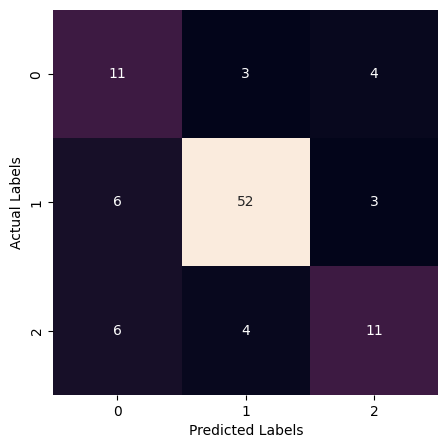

In [ ]:
optimal_xgb = grid_search.best_estimator_
y_pred = optimal_xgb.predict(xgb_X_test)
print(classification_report(y_test, y_pred))
ad.plot_confusion_matrix(y_test, y_pred)

### Scoring

In [ ]:
new_rows = pd.DataFrame(
          np.array([
                    [45, 'm', 'monthly', 37000, 2, 'single', 'y', 2, 0, 1],
                    [25, 'f', 'monthly', 34000, 1, 'single', 'n', 1, 0, 1],
                    [60, 'm', 'monthly', 25000, 0, 'married', 'y', 0, 0, 1],
                  ]),
          columns=X_train.columns
)
new_rows[object_cols] = new_rows[object_cols].astype('category')
new_rows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   AGE       3 non-null      object  
 1   GENDER    3 non-null      category
 2   HOWPAID   3 non-null      category
 3   INCOME    3 non-null      object  
 4   LOANS     3 non-null      object  
 5   MARITAL   3 non-null      category
 6   MORTGAGE  3 non-null      category
 7   NUMCARDS  3 non-null      object  
 8   NUMKIDS   3 non-null      object  
 9   STORECAR  3 non-null      object  
dtypes: category(4), object(6)
memory usage: 772.0+ bytes


In [ ]:
num_cols = new_rows.select_dtypes(include='object').columns
new_rows[num_cols] = new_rows[num_cols].astype('float64')
new_rows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   AGE       3 non-null      float64 
 1   GENDER    3 non-null      category
 2   HOWPAID   3 non-null      category
 3   INCOME    3 non-null      float64 
 4   LOANS     3 non-null      float64 
 5   MARITAL   3 non-null      category
 6   MORTGAGE  3 non-null      category
 7   NUMCARDS  3 non-null      float64 
 8   NUMKIDS   3 non-null      float64 
 9   STORECAR  3 non-null      float64 
dtypes: category(4), float64(6)
memory usage: 772.0 bytes


In [ ]:
optimal_xgb.predict(new_rows)

array([2, 1, 2])